# Measuring BMI in OpenSAFELY-TPP
This short report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [1]:
import os
import pandas as pd

from IPython.display import display, Markdown, Image

pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None 

In [2]:
### CONFIGURE ###
definitions = ['backend_bmi','computed_bmi','derived_bmi','recorded_bmi']
covariates = ['_age_band','_sex','_ethnicity','_region','_imd','_dementia','_diabetes','_hypertension','_learning_disability']
output_path = 'phenotype_validation_bmi'

## Methods
 
We define three variable phenotypes: computed, recorded, and derived BMI. 
* Computed BMI refers to BMI calculated from height and weight measurements. 
* Recorded BMI refers to coded events of BMI. 
* Derived BMI refers to the canonical definition used in the OpenSAFELY backend using the `most_recent_bmi()` function, which returns patients' most recent BMI (in the defined period) either computed from weight and height measurements or, where they are not availble, from recorded BMI values.

To evaluate how well each of these phenotypes are populated, we count the number of patients with each phenotype, number of patients missing each phenotype, and number of patients with multiple phenotypes. We also examine the plausibility of each phenotype by looking at the distribution of measurements and counting values out of the expected range. To evaluate how frequently the BMI phenotypes are recorded, we track the number of new measurements recorded over time and compute the average time between updates.

For each of the checks above, we look at the whole population and across each of the following demographic and clinical subgroups to detect any inequalities.

Demographic covariates:
* Age band 
* Sex
* Ethnicity 
* Region
* IMD

Clinical covariates:
* Dementia
* Diabetes
* Hypertension
* Learning disability

## Results

### Count of Patients

In [3]:
df_patient_counts = pd.read_csv(f'../output/{output_path}/tables/patient_counts_filled.csv').set_index(['group','subgroup'])
display(df_patient_counts)

backend_bmi   computed_bmi  \
group               subgroup                                                 
all                 with records               975.0 (97.5)   965.0 (96.5)   
age_band            0-19                       120.0 (96.0)  125.0 (100.0)   
                    20-29                      140.0 (96.6)   135.0 (93.1)   
                    30-39                     110.0 (100.0)   105.0 (95.5)   
                    40-49                     130.0 (100.0)   125.0 (96.2)   
                    50-59                      115.0 (95.8)   115.0 (95.8)   
                    60-69                      125.0 (96.2)   125.0 (96.2)   
                    70-79                      125.0 (96.2)   125.0 (96.2)   
                    80+                        105.0 (95.5)  110.0 (100.0)   
sex                 F                          490.0 (97.0)   480.0 (95.0)   
                    M                          485.0 (98.0)   485.0 (98.0)   
ethnicity           Asian                      130.0 (96.3)   130.0 (96.3)   
                    Black                      75.0 (100.0)   75.0 (100.0)   
                    Mixed                      260.0 (96.3)   255.0 (94.4)   
                    Other                      30.0 (100.0)   30.0 (100.0)   
                    White                      485.0 (98.0)   475.0 (96.0)   
region              East Midlands               65.0 (92.9)    65.0 (92.9)   
                    East of England            65.0 (100.0)   65.0 (100.0)   
                    London                     135.0 (96.4)  140.0 (100.0)   
                    North East                 65.0 (100.0)   65.0 (100.0)   
                    North West                 60.0 (100.0)    55.0 (91.7)   
                    South East                 110.0 (95.7)   110.0 (95.7)   
                    West Midlands               55.0 (91.7)    55.0 (91.7)   
                    Yorkshire and the Humber   75.0 (100.0)   75.0 (100.0)   
imd                 1 Most deprived            210.0 (97.7)   210.0 (97.7)   
                    2                          185.0 (97.4)   180.0 (94.7)   
                    3                          210.0 (97.7)   205.0 (95.3)   
                    4                          185.0 (97.4)   180.0 (94.7)   
                    5 Least deprived           175.0 (94.6)   180.0 (97.3)   
                    Unknown                    10.0 (100.0)   10.0 (100.0)   
dementia            False                      965.0 (97.5)   955.0 (96.5)   
                    True                       10.0 (100.0)   10.0 (100.0)   
diabetes            False                      965.0 (97.5)   955.0 (96.5)   
                    True                       10.0 (100.0)   10.0 (100.0)   
hypertension        False                      965.0 (97.5)   955.0 (96.5)   
                    True                       10.0 (100.0)   10.0 (100.0)   
learning_disability False                      965.0 (97.5)   955.0 (96.5)   
                    True                       10.0 (100.0)   10.0 (100.0)   

                                                 derived_bmi    recorded_bmi  \
group               subgroup                                                   
all                 with records              1000.0 (100.0)  1000.0 (100.0)   
age_band            0-19                       125.0 (100.0)   125.0 (100.0)   
                    20-29                      145.0 (100.0)   145.0 (100.0)   
                    30-39                      110.0 (100.0)   110.0 (100.0)   
                    40-49                      130.0 (100.0)   130.0 (100.0)   
                    50-59                      120.0 (100.0)   120.0 (100.0)   
                    60-69                      130.0 (100.0)   130.0 (100.0)   
                    70-79                      130.0 (100.0)   130.0 (100.0)   
                    80+                        110.0 (100.0)   110.0 (100.0)   
sex                 F                          

### Count of Missings

In [4]:
df_patient_counts_missing = pd.read_csv(f'../output/{output_path}/tables/patient_counts_missing.csv').set_index(['group','subgroup'])
display(df_patient_counts_missing)

backend_bmi computed_bmi  \
group               subgroup                                            
all                 missing records           25.0 (2.5)   35.0 (3.5)   
age_band            0-19                           - (-)        - (-)   
                    20-29                          - (-)    5.0 (3.4)   
                    30-39                          - (-)    5.0 (4.5)   
                    40-49                          - (-)    5.0 (3.8)   
                    50-59                          - (-)        - (-)   
                    60-69                          - (-)        - (-)   
                    70-79                          - (-)        - (-)   
                    80+                            - (-)        - (-)   
sex                 F                         10.0 (2.0)   20.0 (4.0)   
                    M                         15.0 (3.0)   15.0 (3.0)   
ethnicity           Asian                          - (-)        - (-)   
                    Black                          - (-)        - (-)   
                    Mixed                     10.0 (3.7)   10.0 (3.7)   
                    Other                          - (-)        - (-)   
                    White                     10.0 (2.0)   20.0 (4.0)   
region              East Midlands                  - (-)        - (-)   
                    East of England                - (-)        - (-)   
                    London                         - (-)        - (-)   
                    North East                     - (-)        - (-)   
                    North West                     - (-)        - (-)   
                    South East                     - (-)        - (-)   
                    West Midlands                  - (-)        - (-)   
                    Yorkshire and the Humber       - (-)        - (-)   
imd                 1 Most deprived                - (-)        - (-)   
                    2                          5.0 (2.6)   10.0 (5.3)   
                    3                              - (-)   10.0 (4.7)   
                    4                              - (-)   10.0 (5.3)   
                    5 Least deprived           5.0 (2.7)        - (-)   
                    Unknown                        - (-)        - (-)   
dementia            False                     25.0 (2.5)   35.0 (3.5)   
                    True                           - (-)        - (-)   
diabetes            False                     25.0 (2.5)   35.0 (3.5)   
                    True                           - (-)        - (-)   
hypertension        False                     25.0 (2.5)   35.0 (3.5)   
                    True                           - (-)        - (-)   
learning_disability False                     25.0 (2.5)   35.0 (3.5)   
                    True                           - (-)        - (-)   

                                             derived_bmi recorded_bmi  \
group               subgroup                                            
all                 missing records                - (-)        - (-)   
age_band            0-19                           - (-)        - (-)   
                    20-29                          - (-)        - (-)   
                    30-39                          - (-)        - (-)   
                    40-49                          - (-)        - (-)   
                    50-59                          - (-)        - (-)   
                    60-69                          - (-)        - (-)   
                    70-79                          - (-)        - (-)   
                    80+                            - (-)        - (-)   
sex                 F                              - (-)        - (-)   
                    M                              - (-)        - (-)   
ethnicity           Asian                          - (-)        - (-)   
                    Black                          - (-)        - (-)   
                    Mixed    

### Overlapping Definitions

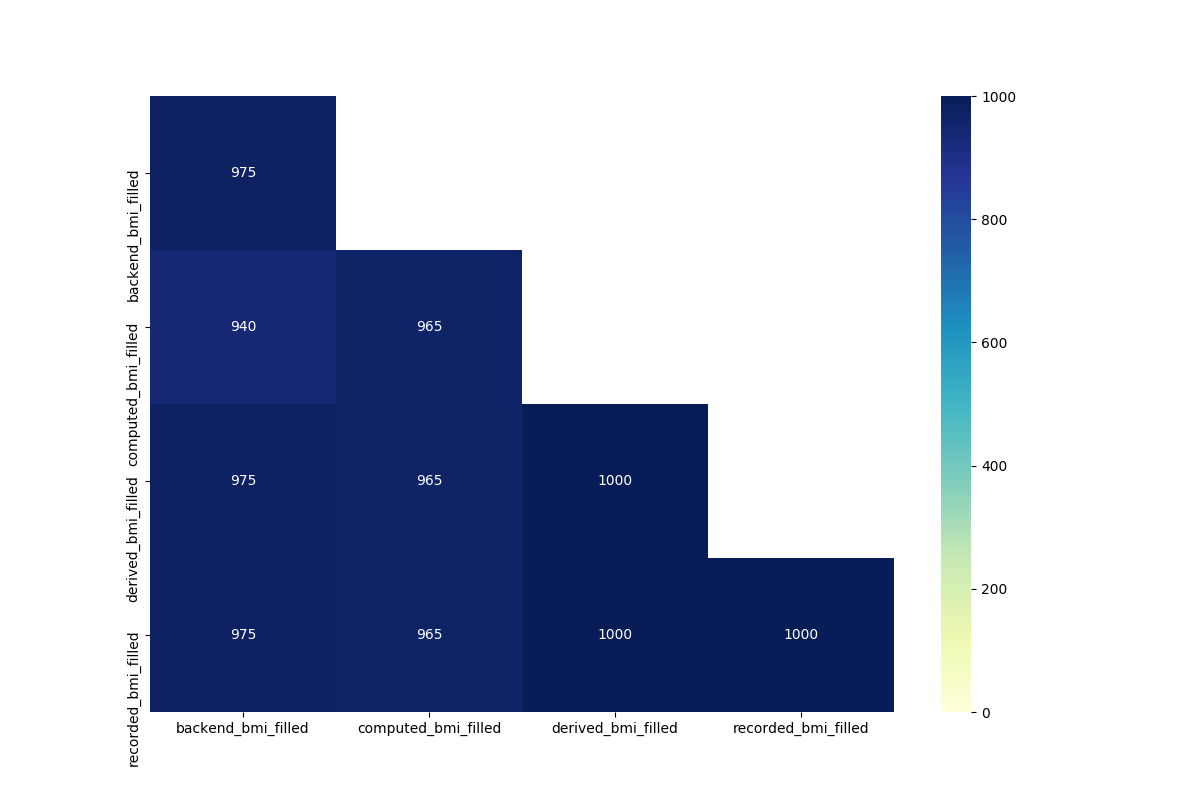

In [5]:
display(Image(f"../output/{output_path}/figures/heatmap.png"))

### Distribution of Values

#### Comparison of Distributions

mean  count
backend_bmi   25.777015   2980
computed_bmi  25.787607   2960
derived_bmi   28.044715   4615
recorded_bmi  22.049518   6860

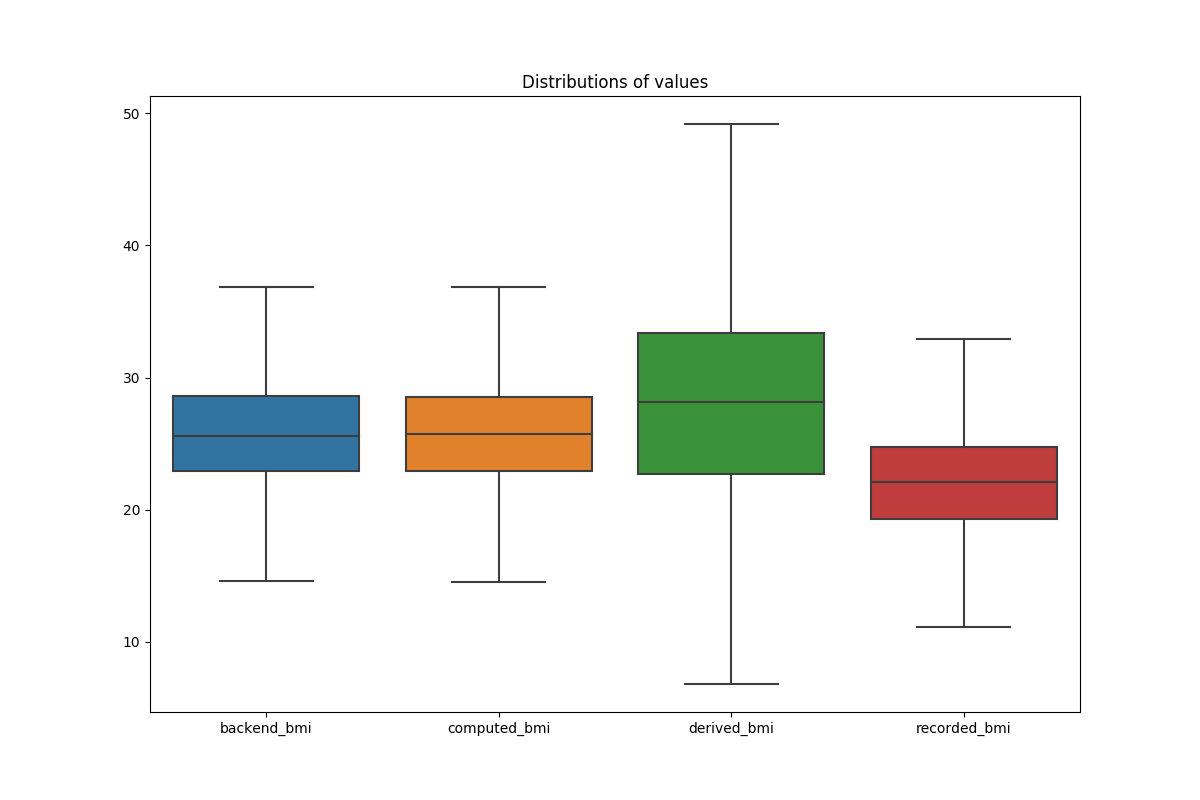

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
age_band                                                       
0-19            26.035367         25.968196        27.927611   
20-29           25.843210         26.006603        27.934563   
30-39           25.573146         25.372562        27.518141   
40-49           25.662604         25.896351        28.638340   
50-59           25.939924         25.801619        28.172533   
60-69           25.698420         25.826004        28.213466   
70-79           25.747814         25.860576        28.291753   
80+             25.677165         25.417954        27.543698   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
age_band                                                                      
0-19             21.842604             380              375             595   
20-29            21.858911             455              450             670   
30-39            22.251943             330              310             515   
40-49            22.207487             390              365             590   
50-59            22.321756             350              340             570   
60-69            21.965676             385              390             595   
70-79            21.902883             365              395             575   
80+              22.116236             325              340             505   

          ct_recorded_bmi  
age_band                   
0-19                  855  
20-29                 995  
30-39                 765  
40-49                 900  
50-59                 835  
60-69                 880  
70-79                 900  
80+                   735

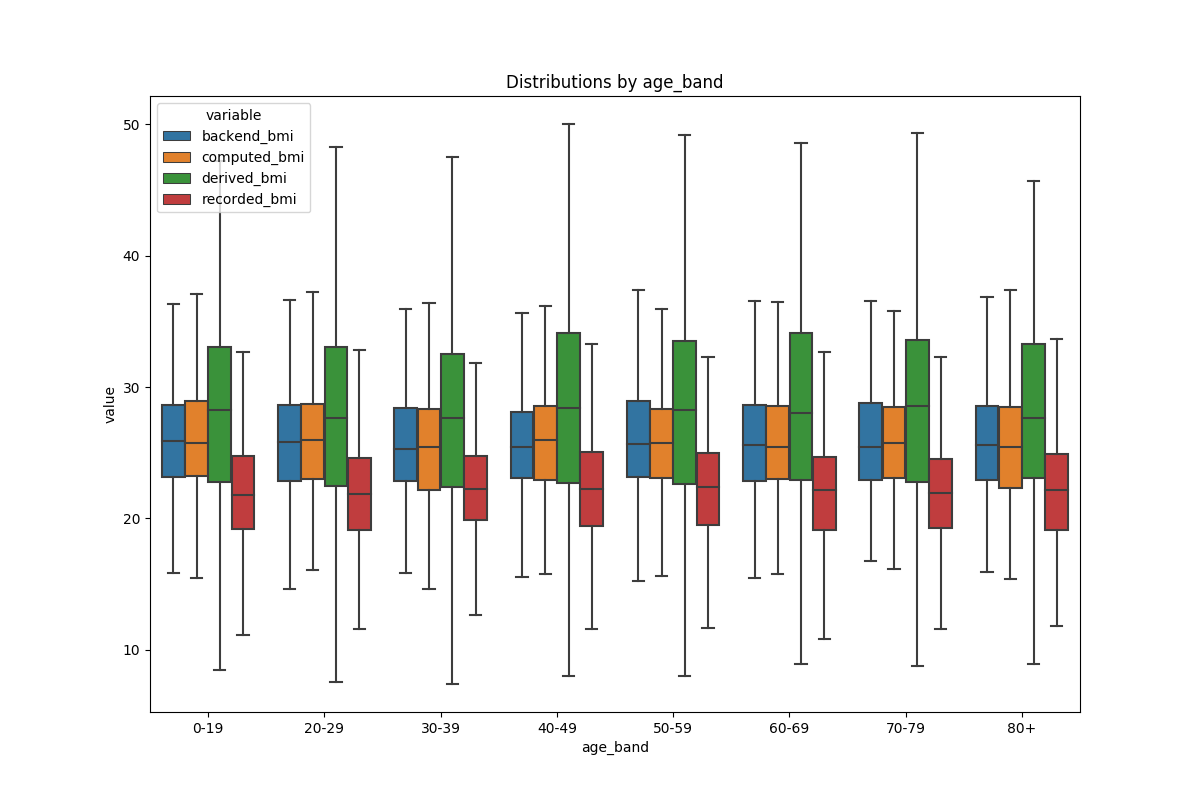

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  avg_recorded_bmi  \
sex                                                                         
F          25.772164         25.967211        28.174665         22.074861   
M          25.781991         25.598032        27.910995         22.023759   

     ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  ct_recorded_bmi  
sex                                                                    
F              1510             1520            2340             3460  
M              1470             1440            2275             3400

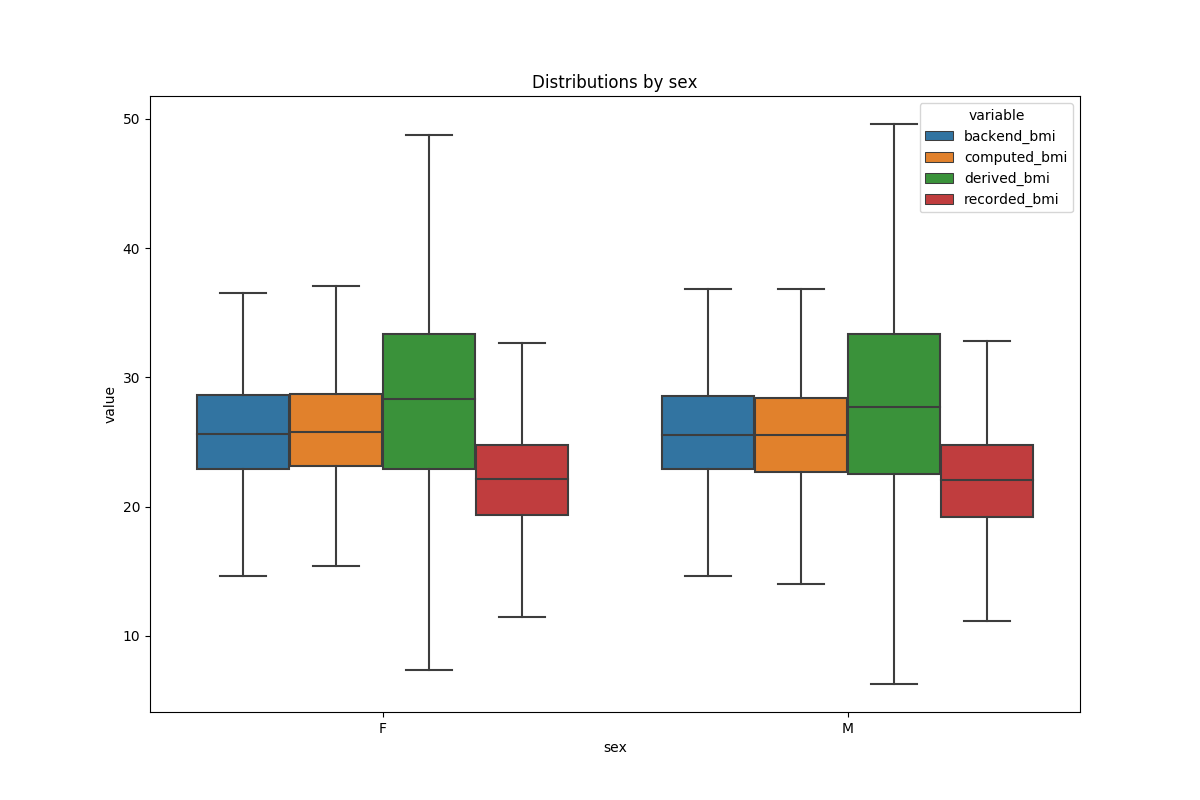

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
ethnicity                                                       
Asian            26.056681         25.807378        27.775479   
Black            25.219009         25.572647        27.621574   
Mixed            25.817182         25.956402        28.360922   
Other            26.315065         25.783268        28.858993   
White            25.726171         25.725489        27.957234   

           avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
ethnicity                                                                      
Asian             22.211058             425              385             630   
Black             21.729070             205              240             345   
Mixed             22.113350             810              795            1230   
Other             21.721030              70               90             150   
White             22.039561            1470             1455            2260   

           ct_recorded_bmi  
ethnicity                   
Asian                  910  
Black                  495  
Mixed                 1865  
Other                  225  
White                 3365

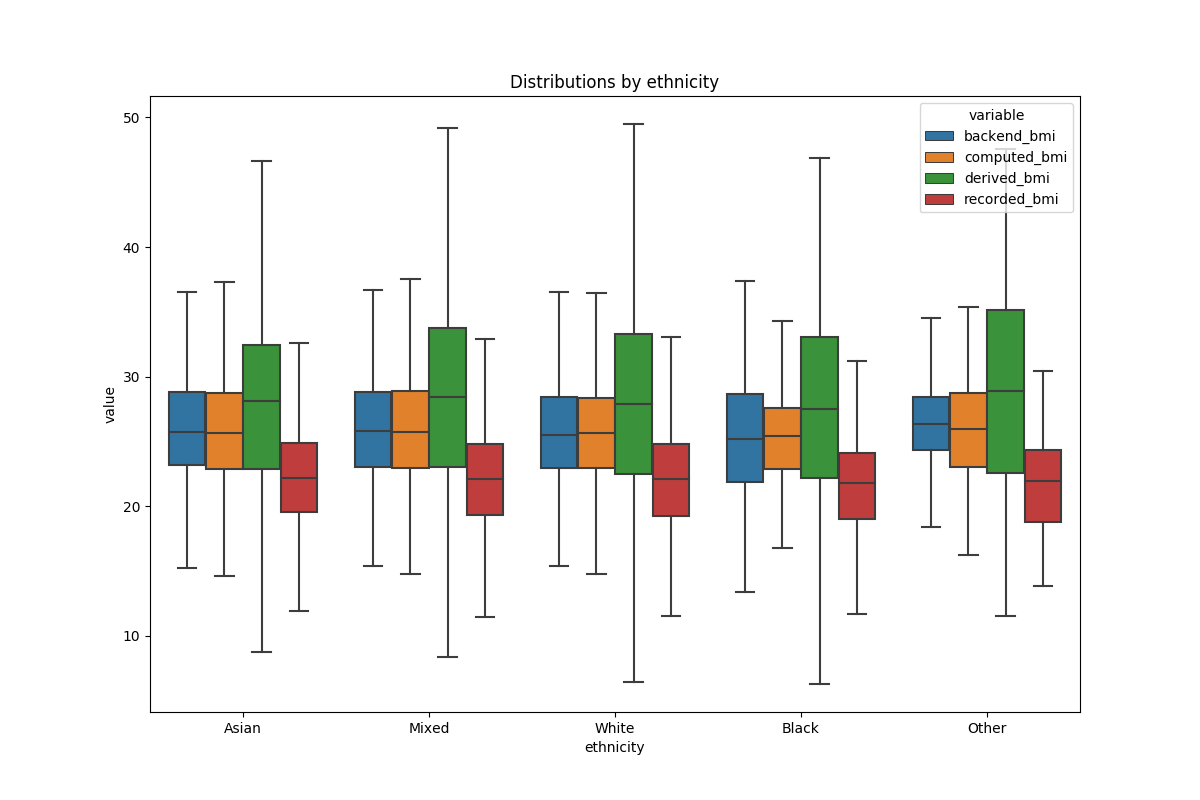

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
region                                                                         
East Midlands                   25.899181         26.022057        27.925018   
East of England                 26.101226         25.698865        28.235327   
London                          25.848178         25.773222        27.905379   
North East                      25.368544         25.936031        28.546705   
North West                      25.793727         25.696569        28.291024   
South East                      25.484237         26.016121        27.752323   
West Midlands                   26.211129         25.549754        28.575065   
Yorkshire and the Humber        26.034943         25.803181        28.116385   

                          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
region                                                                        
East Midlands                    21.908934             200              210   
East of England                  21.944781             225              215   
London                           22.310523             425              415   
North East                       21.885811             180              205   
North West                       21.992339             180              180   
South East                       22.060653             320              340   
West Midlands                    22.015019             185              185   
Yorkshire and the Humber         22.030387             235              240   

                          ct_derived_bmi  ct_recorded_bmi  
region                                                     
East Midlands                        325              470  
East of England                      325              450  
London                               665              980  
North East                           285              455  
North West                           265              420  
South East                           525              760  
West Midlands                        275              385  
Yorkshire and the Humber             355              530

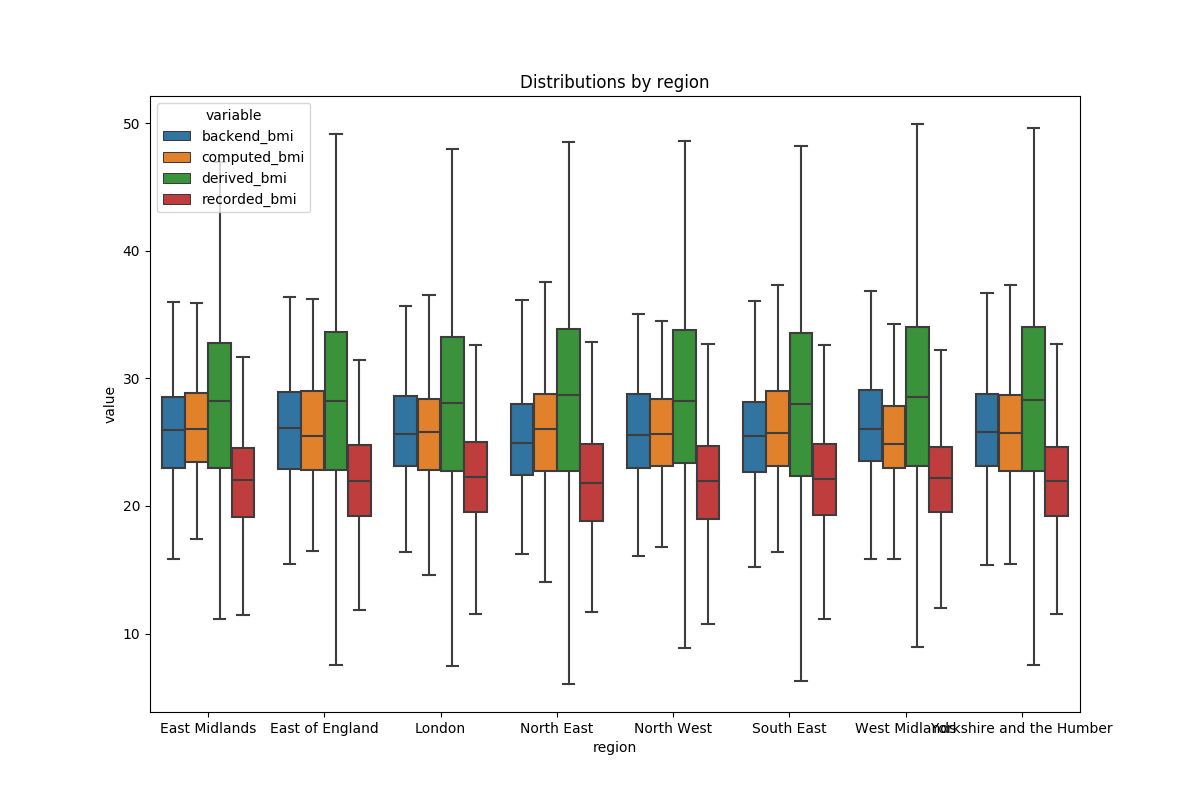

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
imd                                                                    
1 Most deprived         25.737852         25.779472        28.090437   
2                       25.857003         26.012537        28.062753   
3                       25.890754         25.811753        27.873431   
4                       25.611408         25.496323        28.224681   
5 Least deprived        25.751738         25.883315        27.943307   
Unknown                 26.159898         24.762429        29.123030   

                  avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
imd                                                                   
1 Most deprived          21.984137             635              650   
2                        22.204450             560              565   
3                        21.961119             655              645   
4                        22.175506             535              520   
5 Least deprived         21.916956             570              540   
Unknown                  22.458841              20               35   

                  ct_derived_bmi  ct_recorded_bmi  
imd                                                
1 Most deprived              985             1480  
2                            875             1290  
3                           1010             1495  
4                            850             1300  
5 Least deprived             850             1225  
Unknown                       40               65

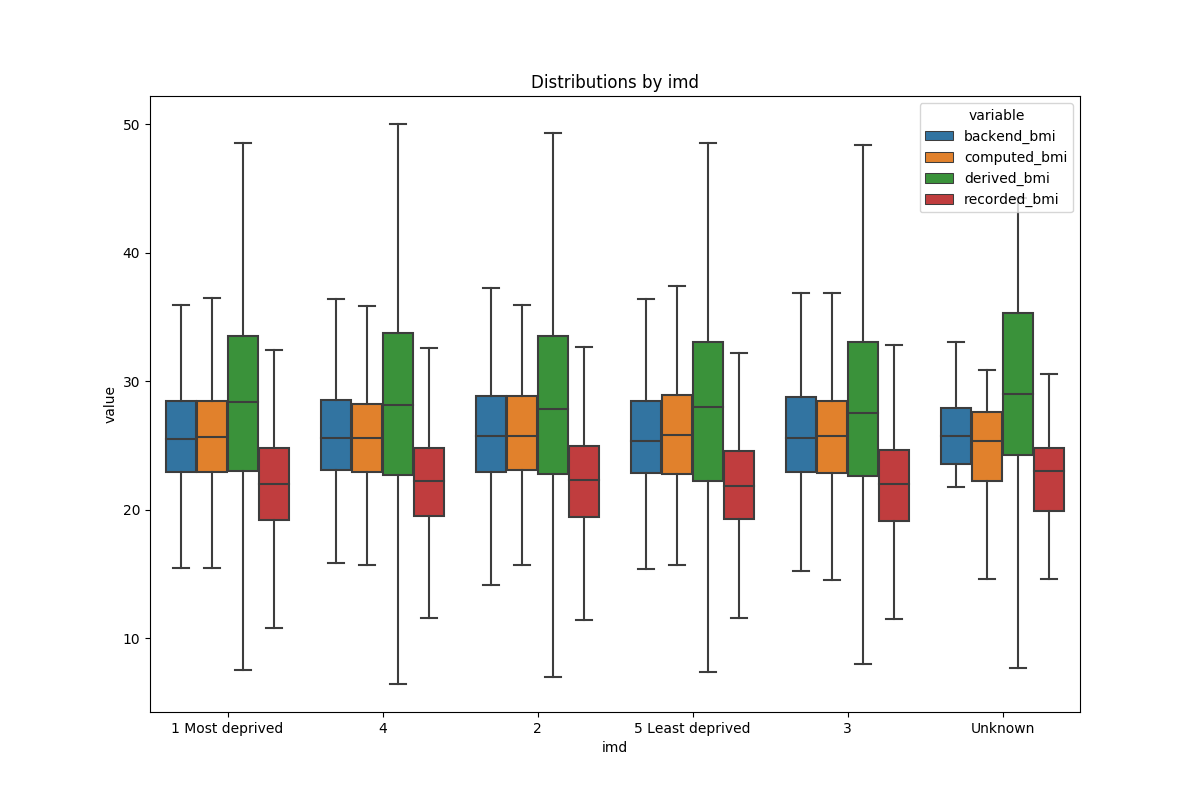

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
dementia                                                       
False           25.780876         25.779498        28.042982   
True            25.320646         26.703355        28.228988   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
dementia                                                                      
False            22.042545            2955             2935            4575   
True             22.756559              25               25              45   

          ct_recorded_bmi  
dementia                   
False                6795  
True                   65

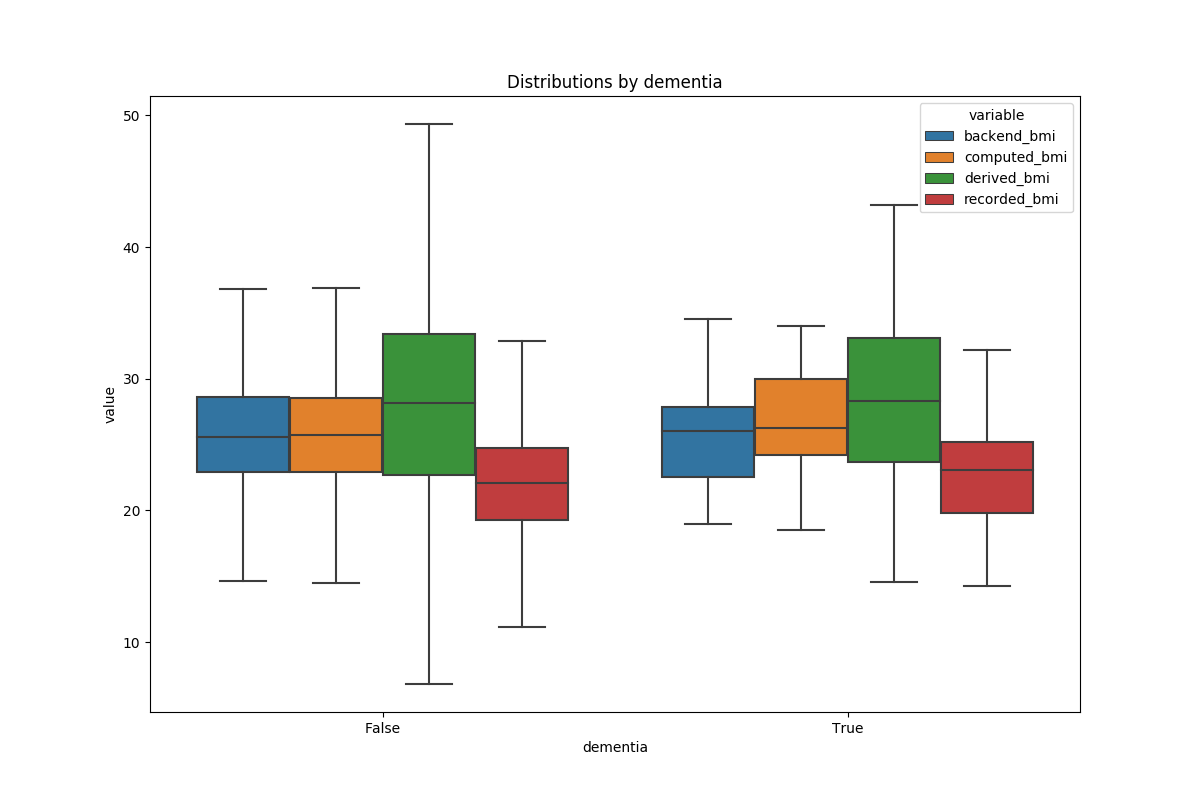

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
diabetes                                                       
False           25.766989         25.774668        28.041092   
True            26.962101         27.194172        28.369019   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
diabetes                                                                      
False            22.057020            2955             2935            4565   
True             21.321869              25               25              50   

          ct_recorded_bmi  
diabetes                   
False                6790  
True                   70

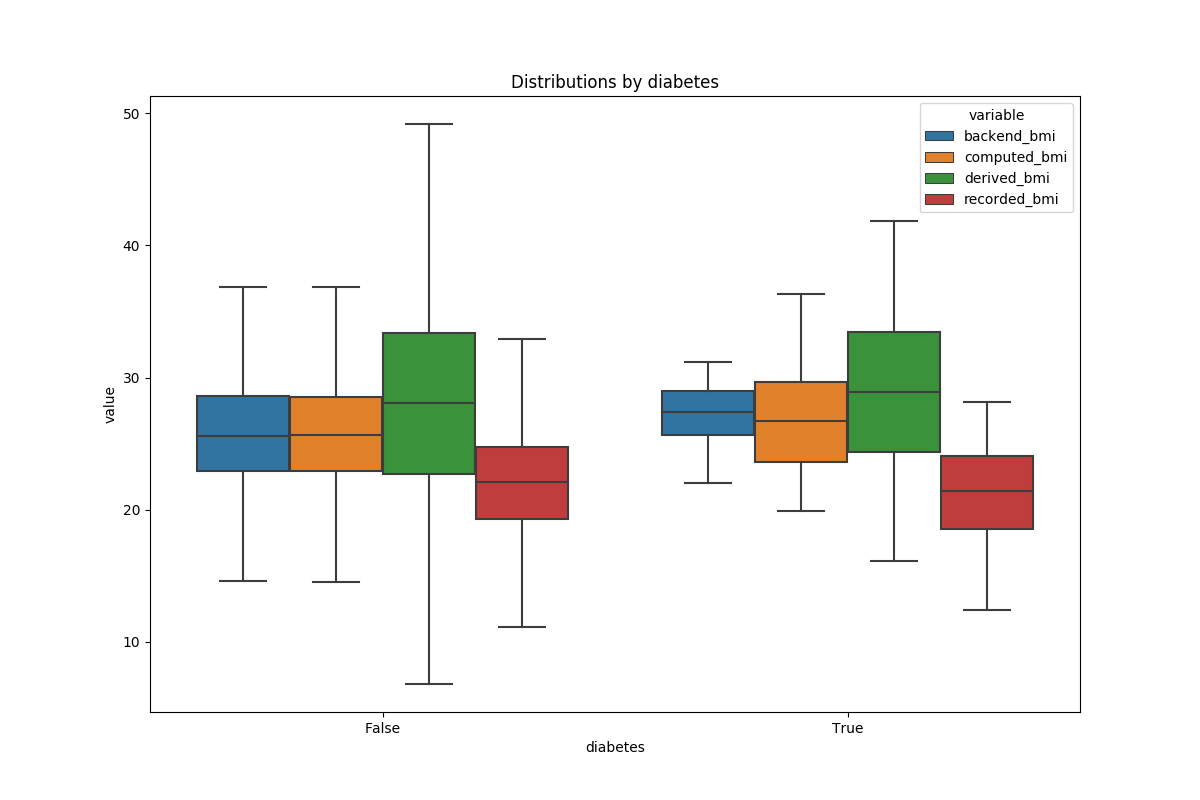

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
hypertension                                                       
False               25.778016         25.782259        28.022708   
True                25.653767         26.310309        30.280171   

              avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
hypertension                                                      
False                22.052434            2955             2930   
True                 21.758345              25               30   

              ct_derived_bmi  ct_recorded_bmi  
hypertension                                   
False                   4570             6790  
True                      45               70

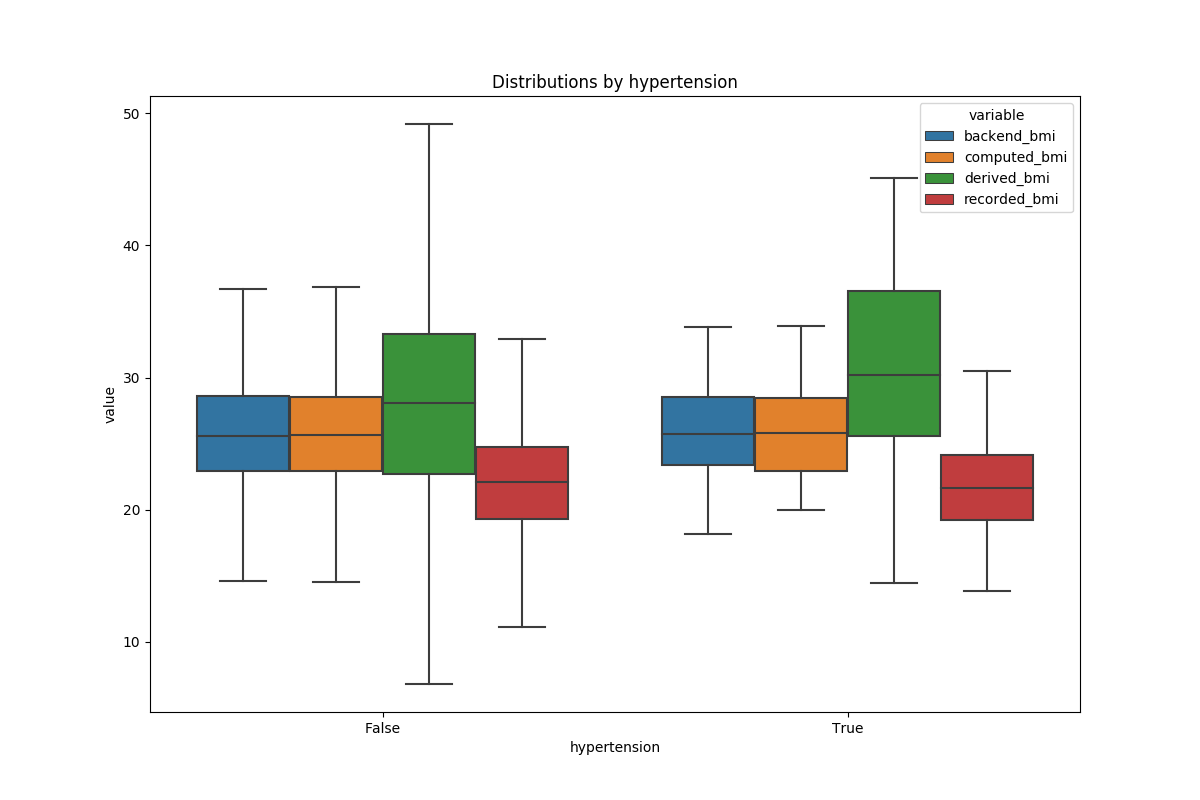

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
learning_disability                                                       
False                      25.781418         25.792674        28.046015   
True                       25.371366         25.363877        27.921028   

                     avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
learning_disability                                                      
False                       22.043803            2950             2925   
True                        22.596002              30               35   

                     ct_derived_bmi  ct_recorded_bmi  
learning_disability                                   
False                          4570             6790  
True                             50               70

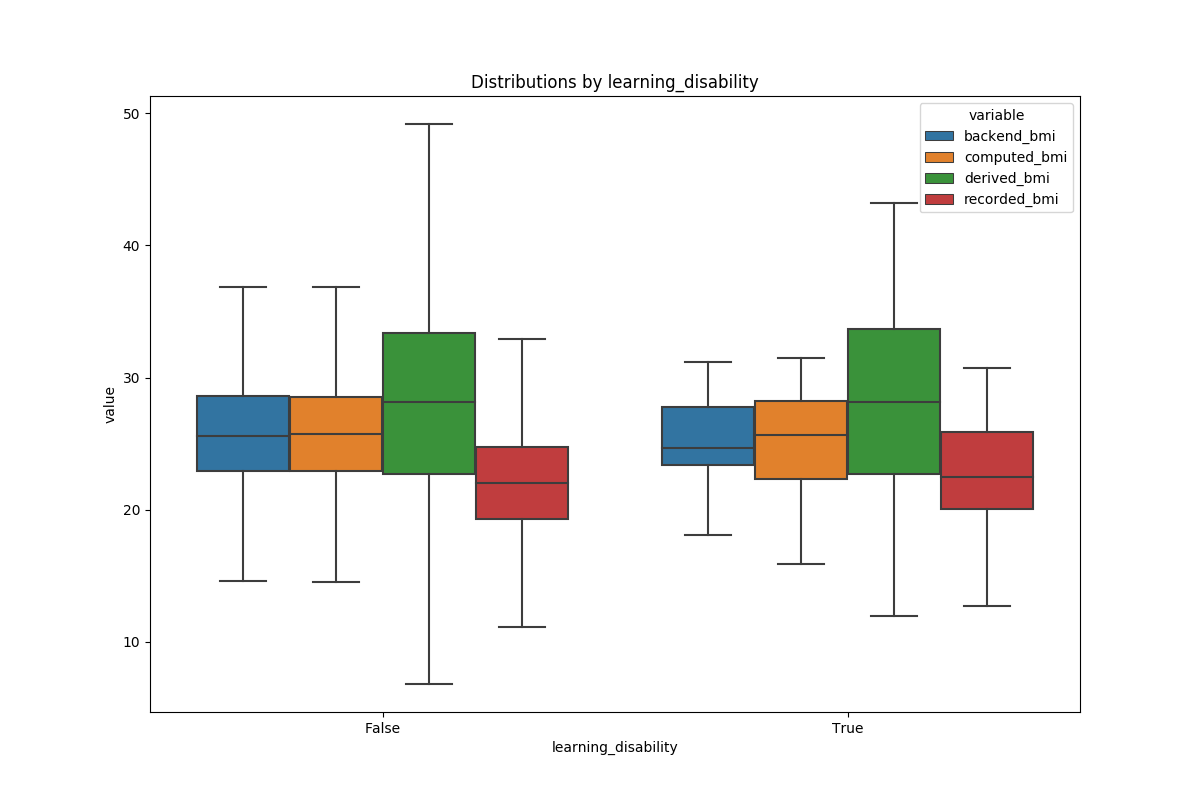

In [6]:
for suffix in [''] + covariates:    
    df_distribution = pd.read_csv(f'../output/{output_path}/tables/avg_value{suffix}.csv', index_col=0)
    display(df_distribution)
    
    img_exist = os.path.exists(f'../output/{output_path}/figures/distribution{suffix}.png')
    
    if img_exist:
        img_distribution = Image(f'../output/{output_path}/figures/distribution{suffix}.png')
        display(img_distribution)
    else: 
        print('Plot redacted due to low counts.')

#### Out-of-Range Values

In [7]:
# for suffix in [''] + covariates: 
#     df_oor = pd.read_csv(f'../output/{output_path}/tables/out_of_range{suffix}.csv', index_col=0)
#     display(df_oor)
    
#     img_exist = os.path.exists(f'../output/{output_path}/figures/out_of_range{suffix}.png')
    
#     if img_exist:
#         img_oor = Image(f'../output/{output_path}/figures/out_of_range{suffix}.png')
#         display(img_oor)
#     else: 
#         print('Plot redacted due to low counts.')
print('Removed while fixing errors...')

Removed while fixing errors...


### New Records Over Time

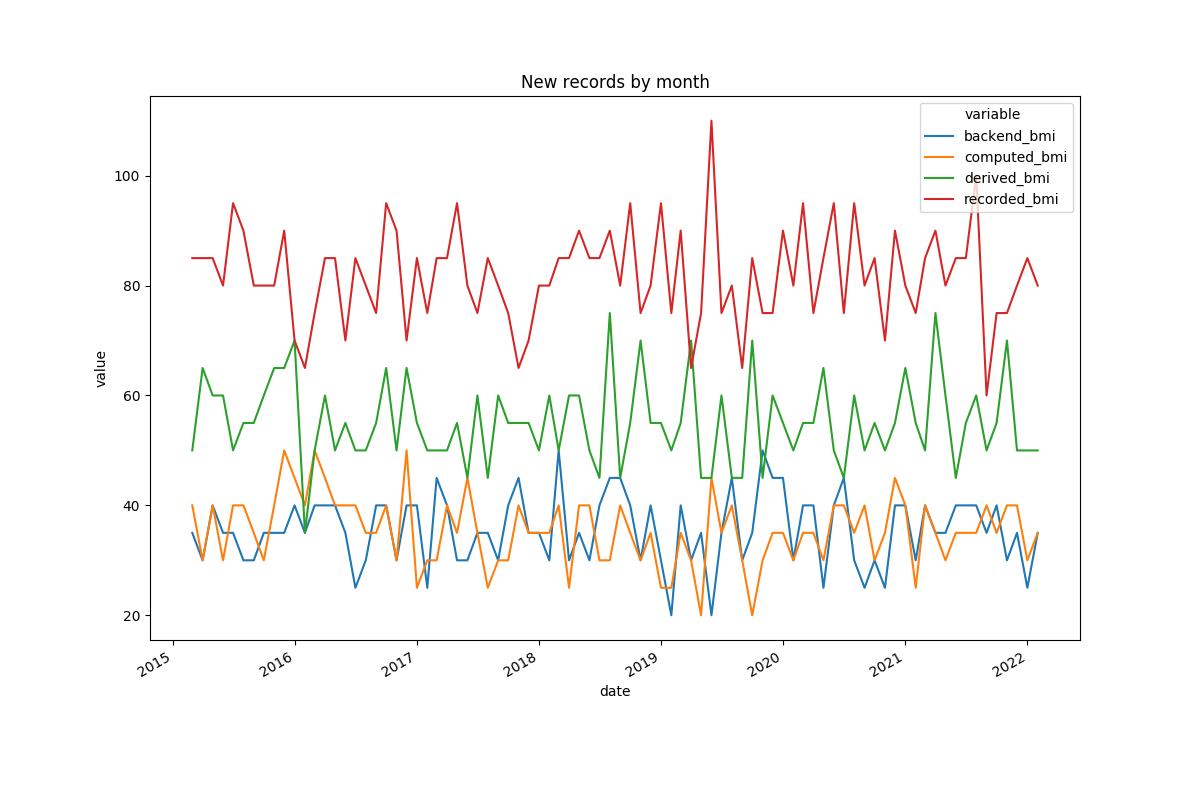

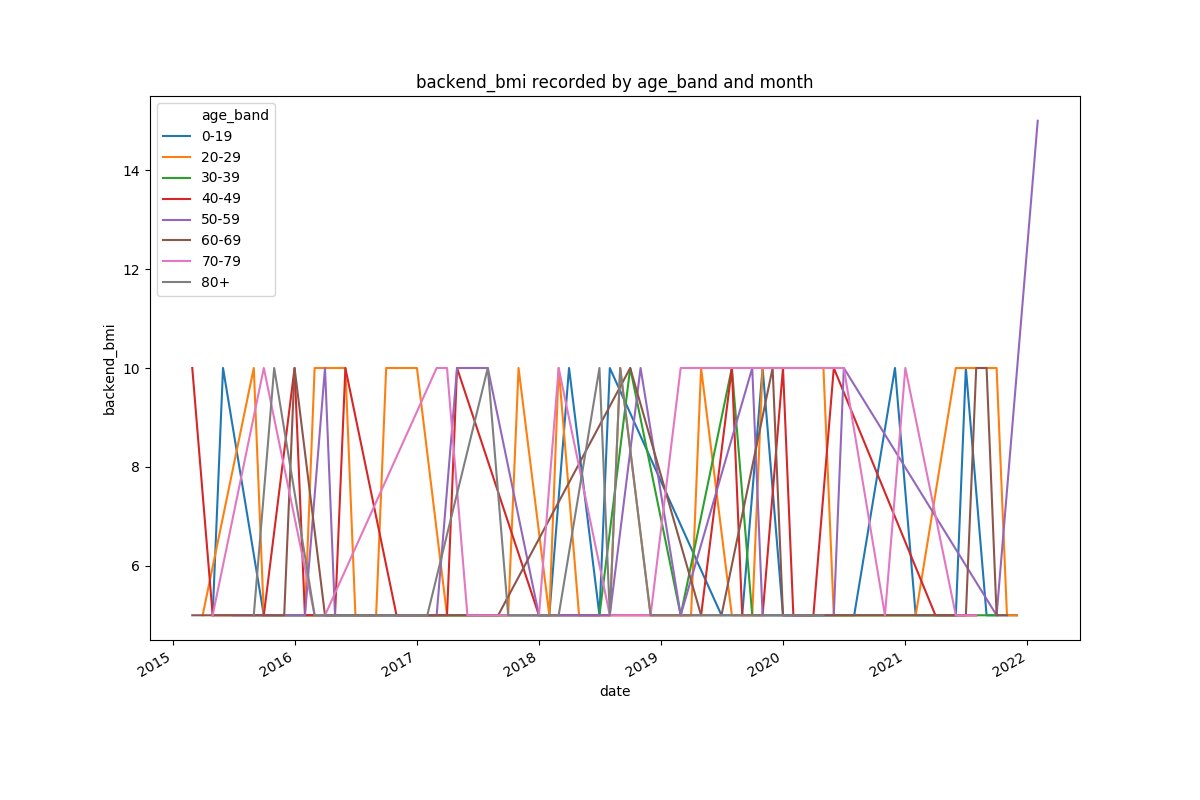

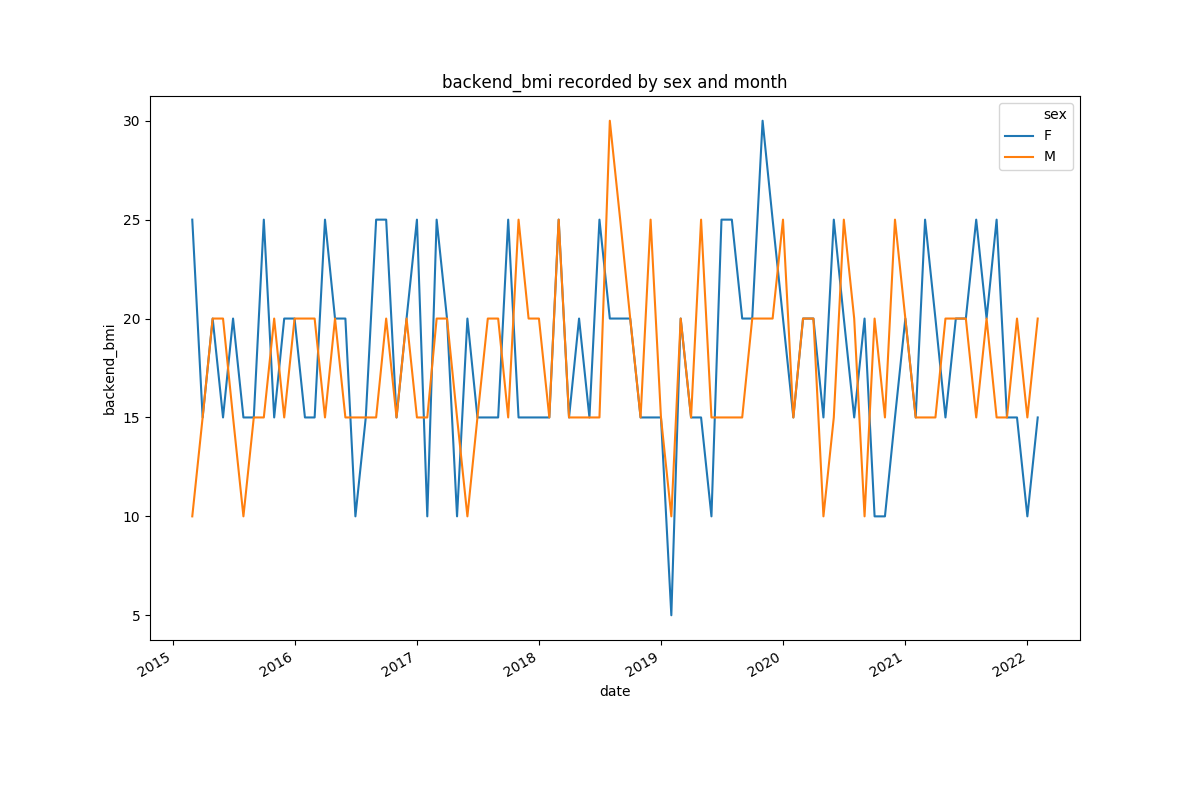

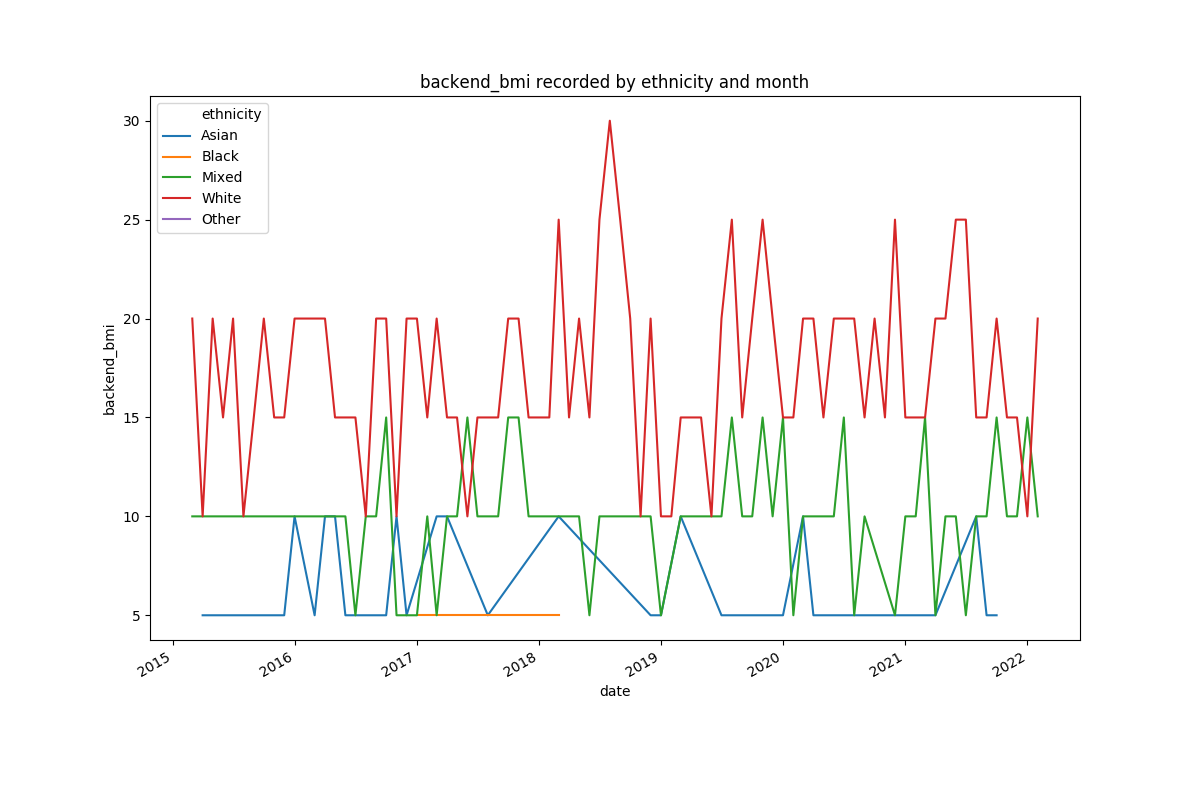

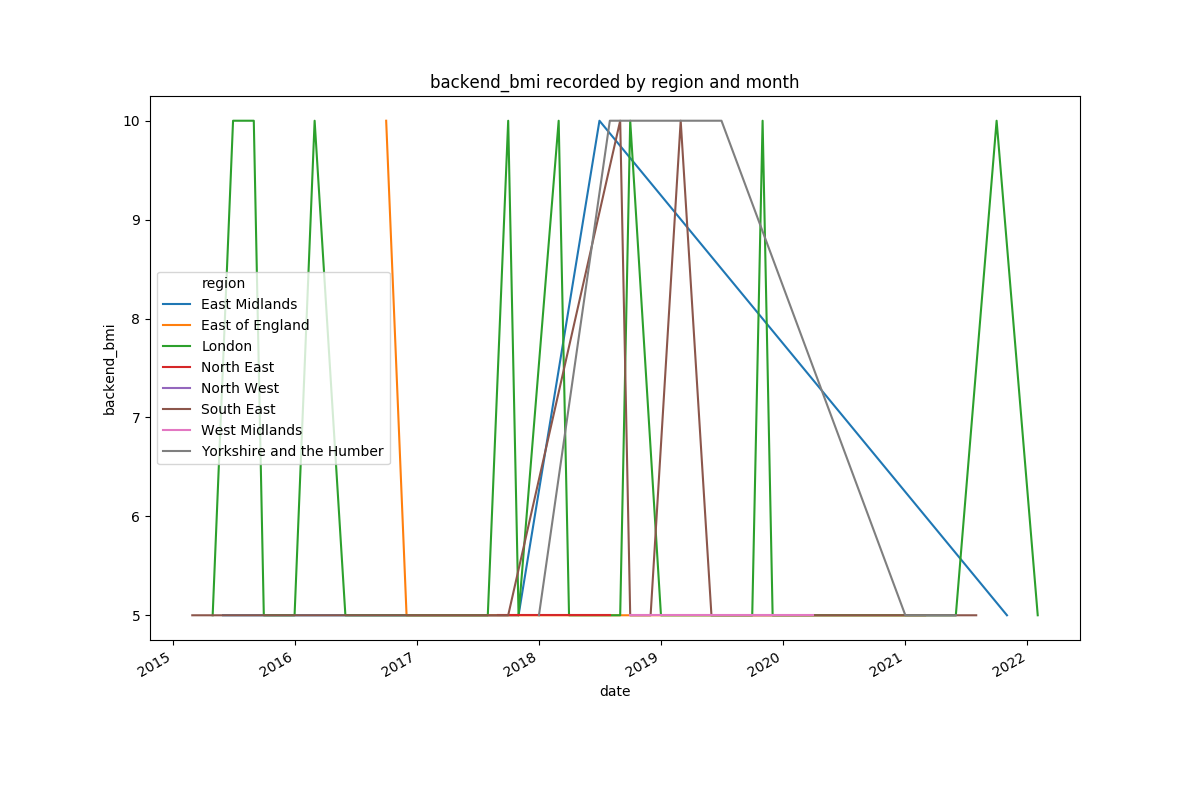

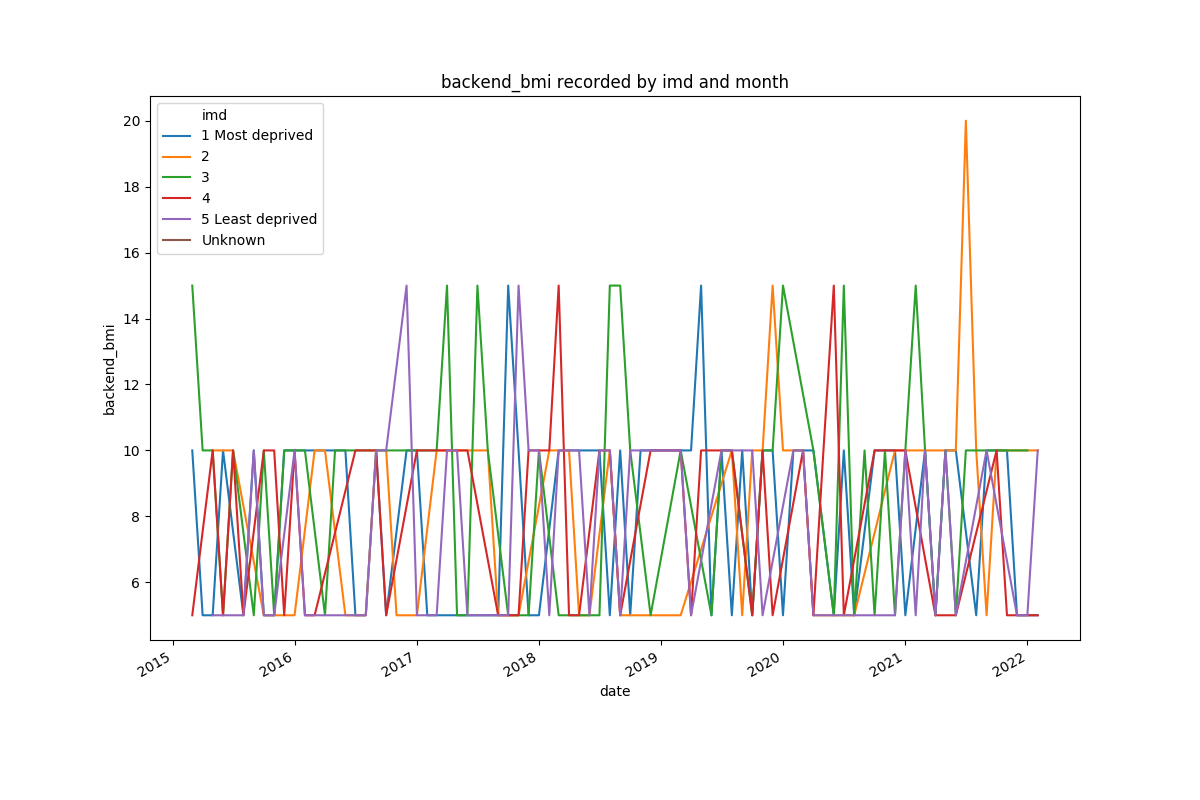

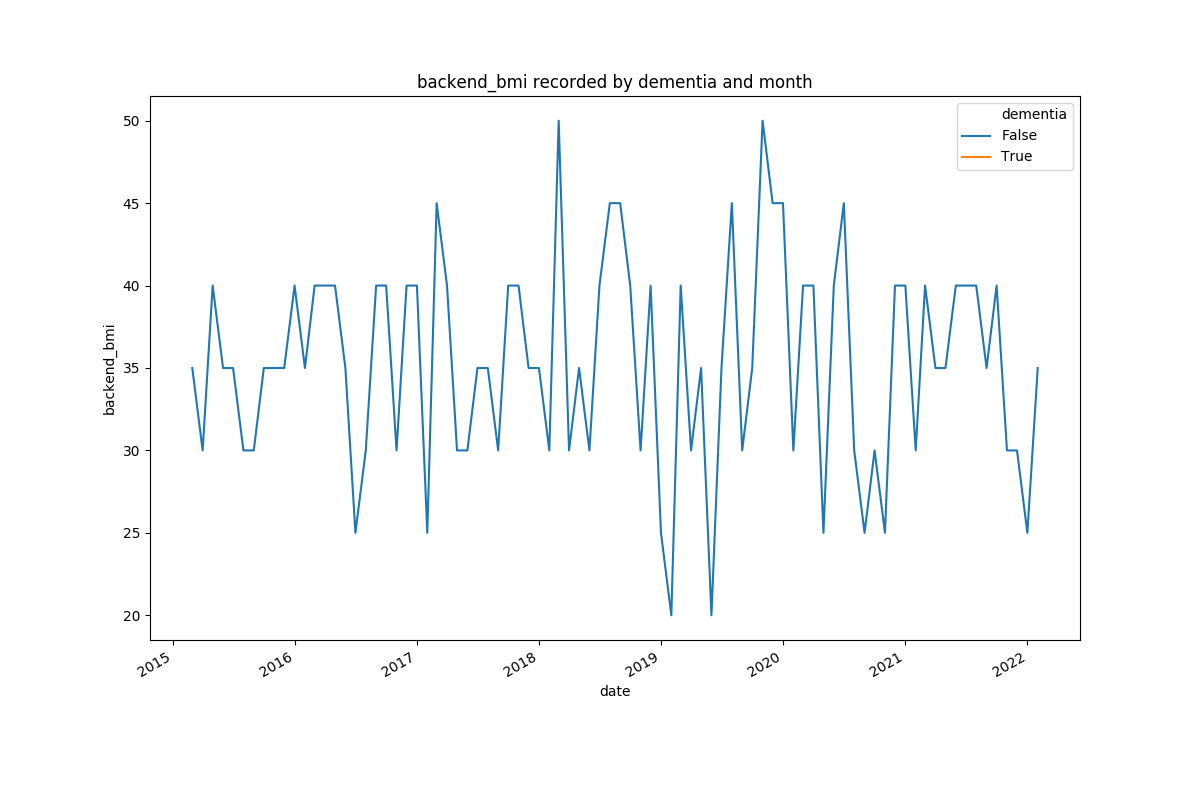

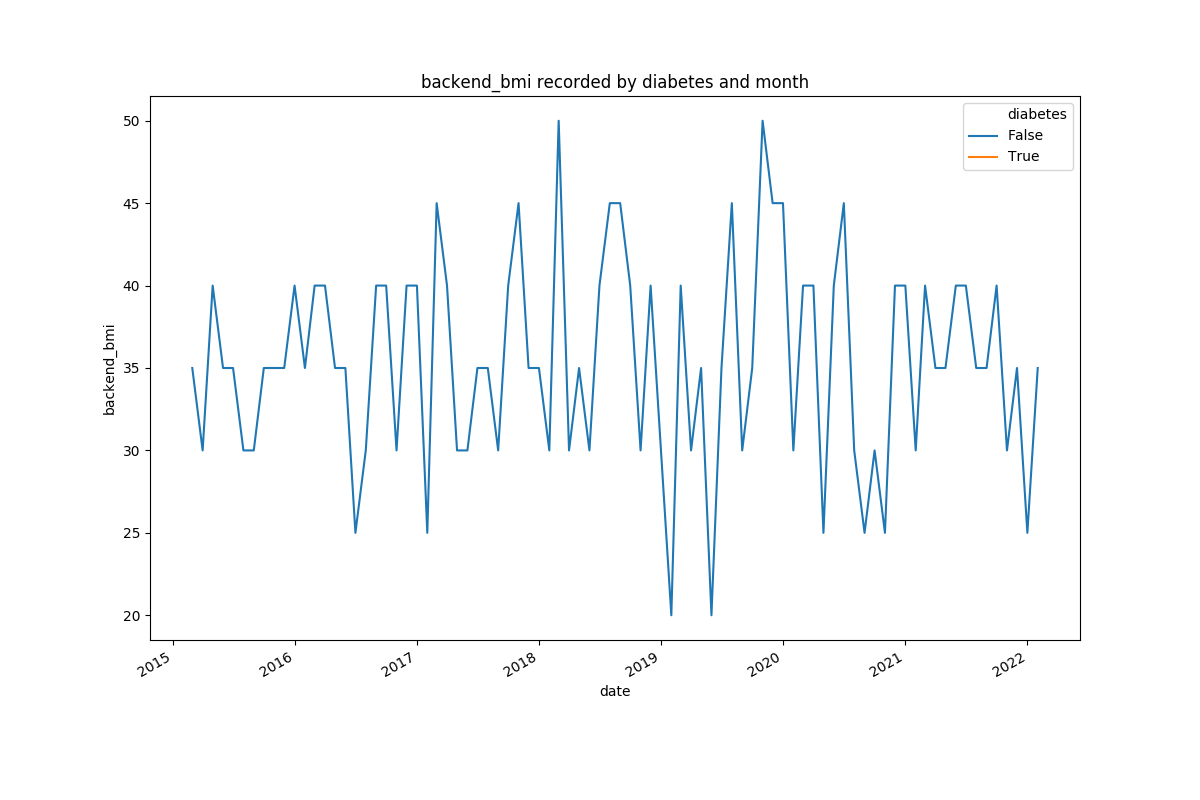

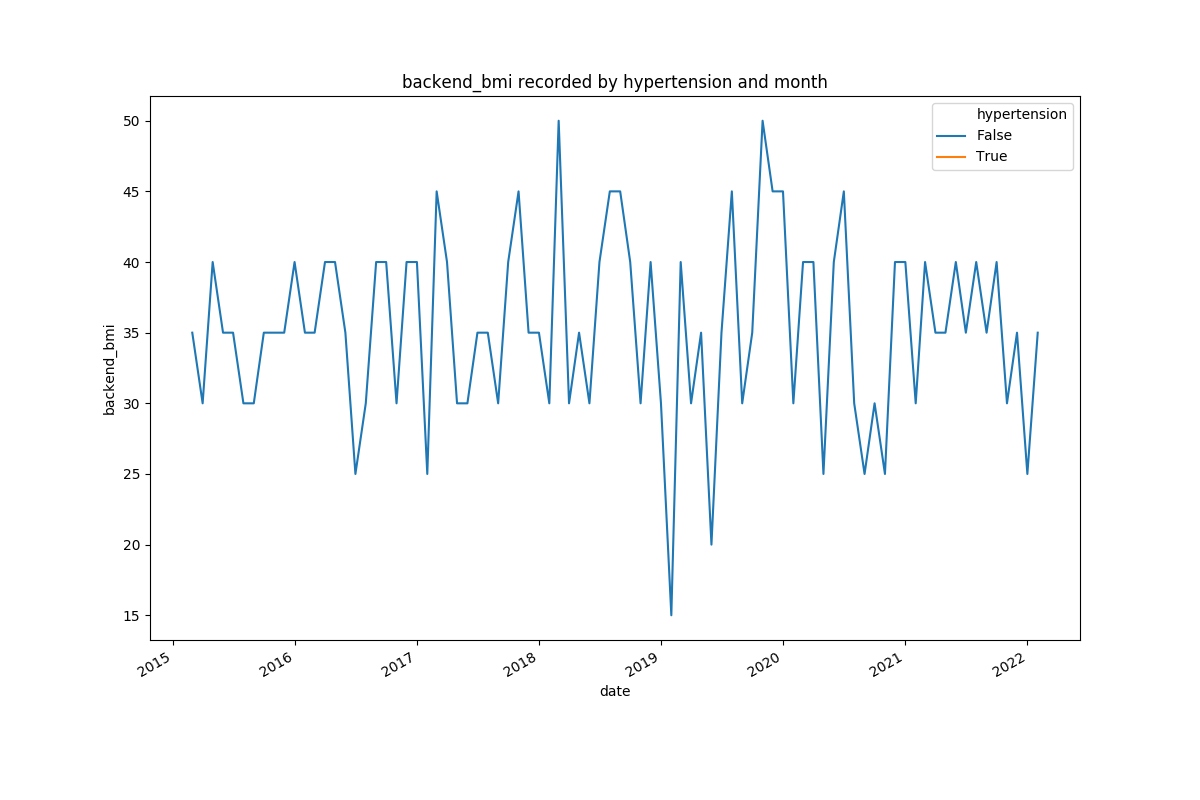

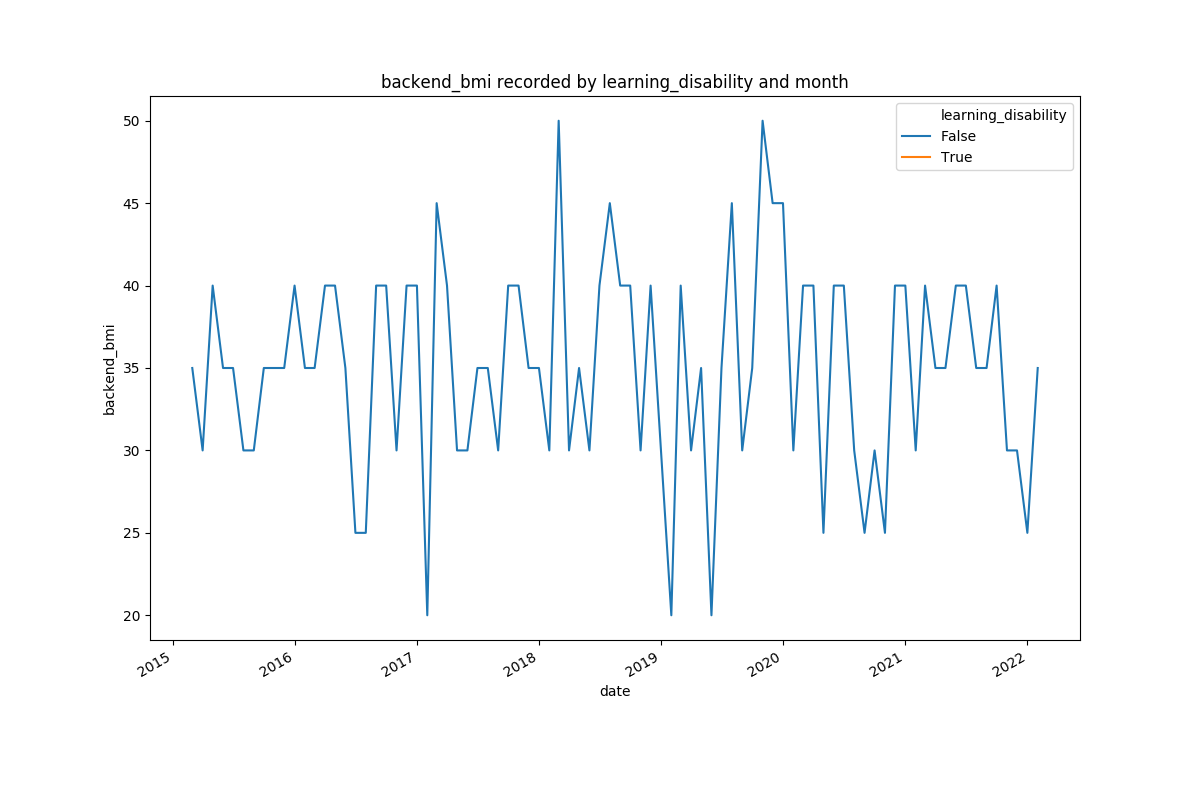

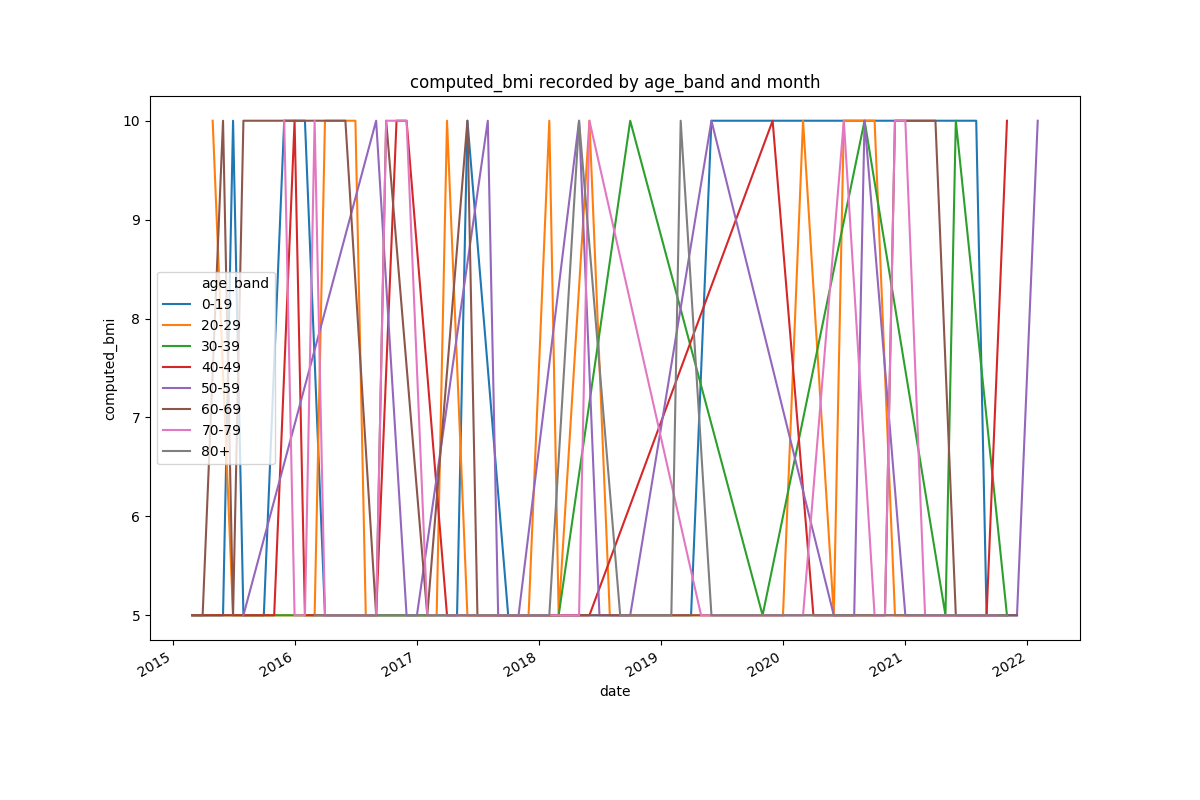

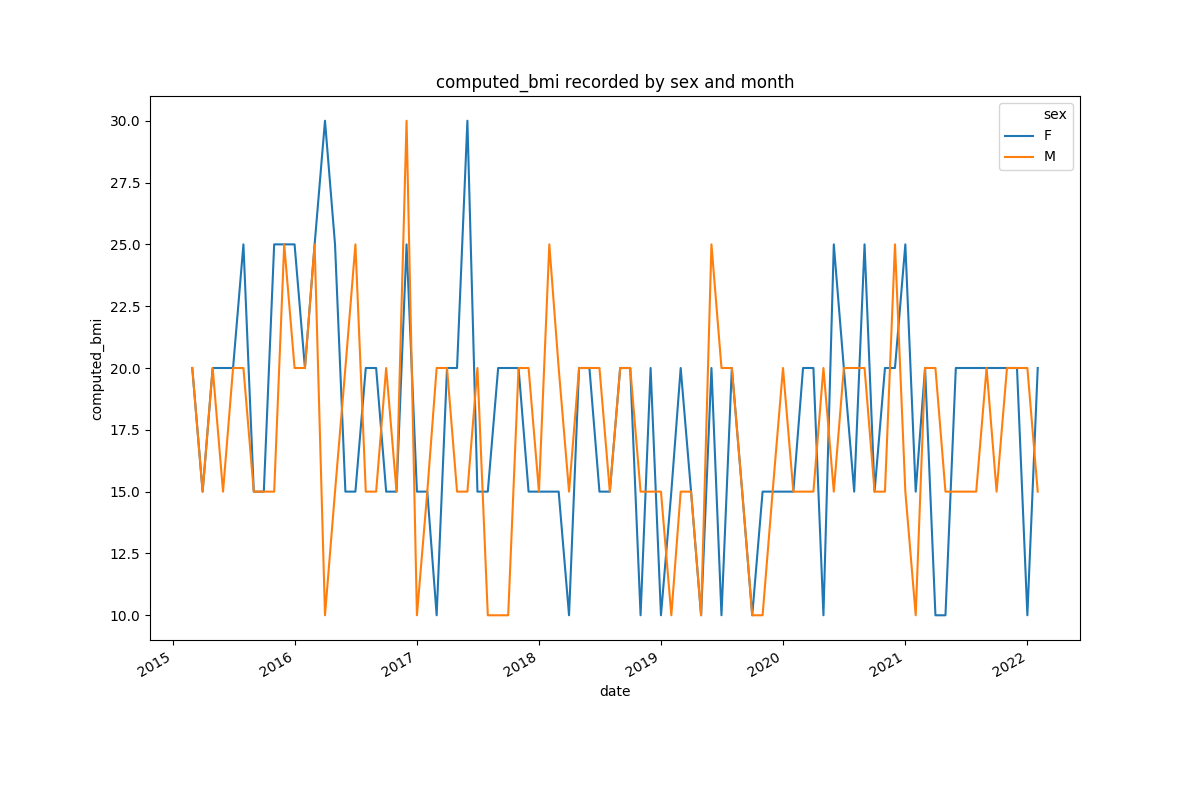

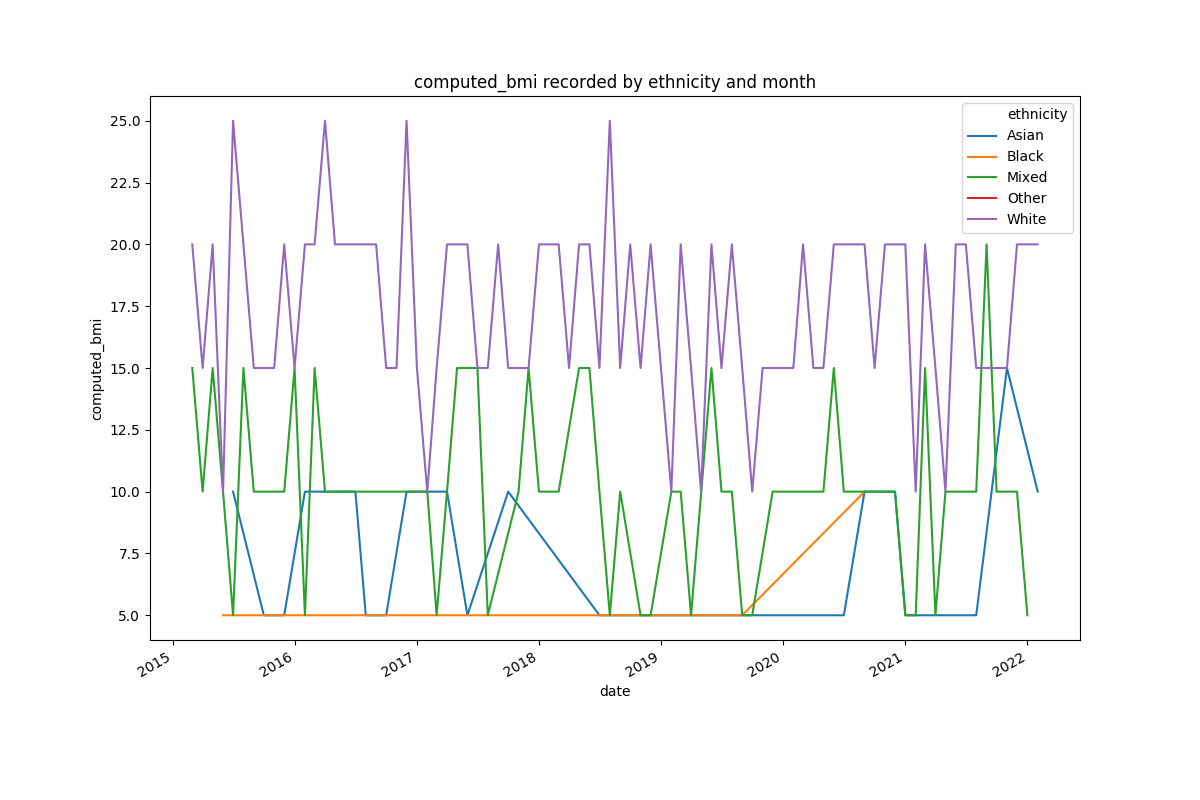

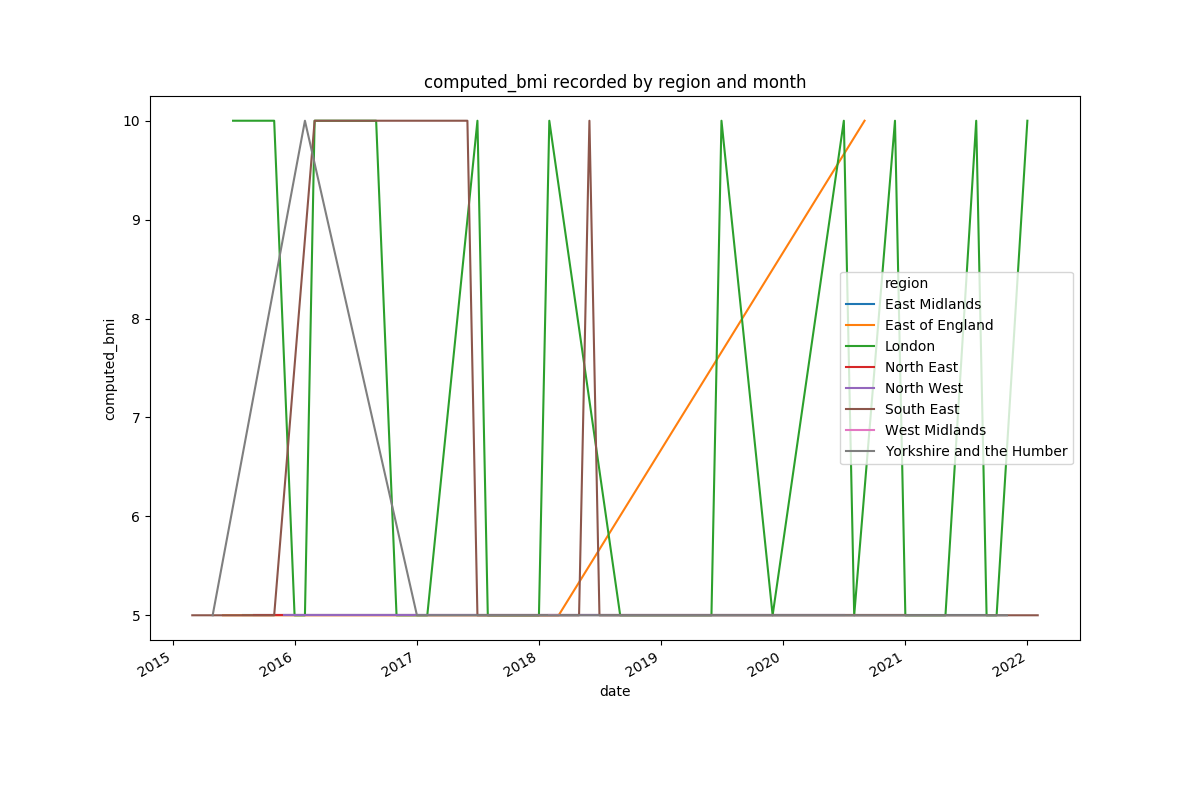

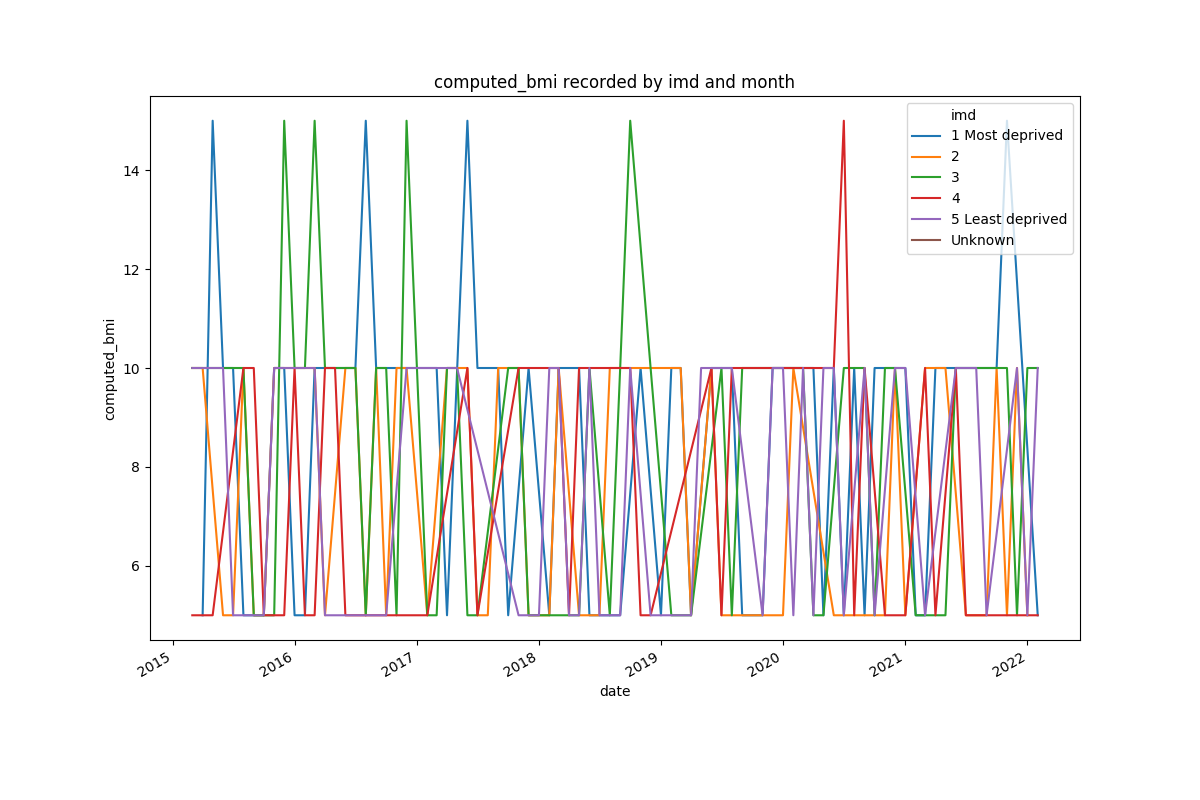

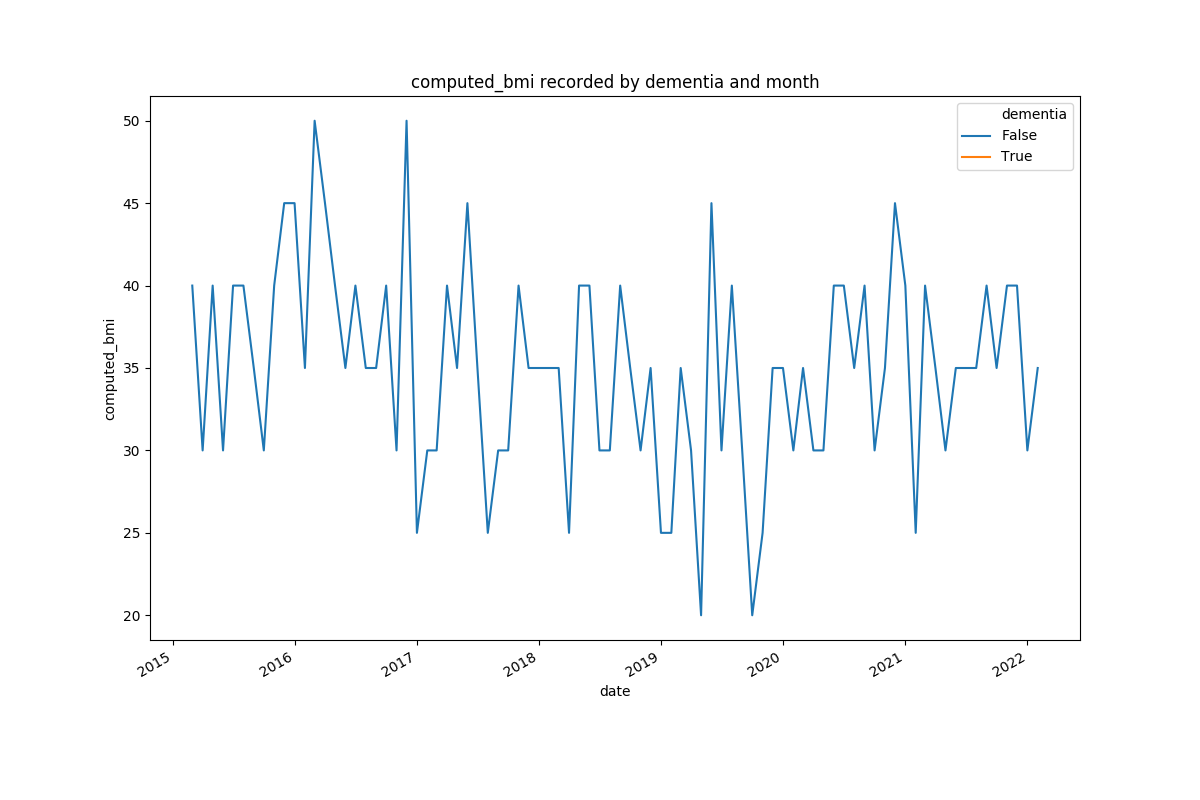

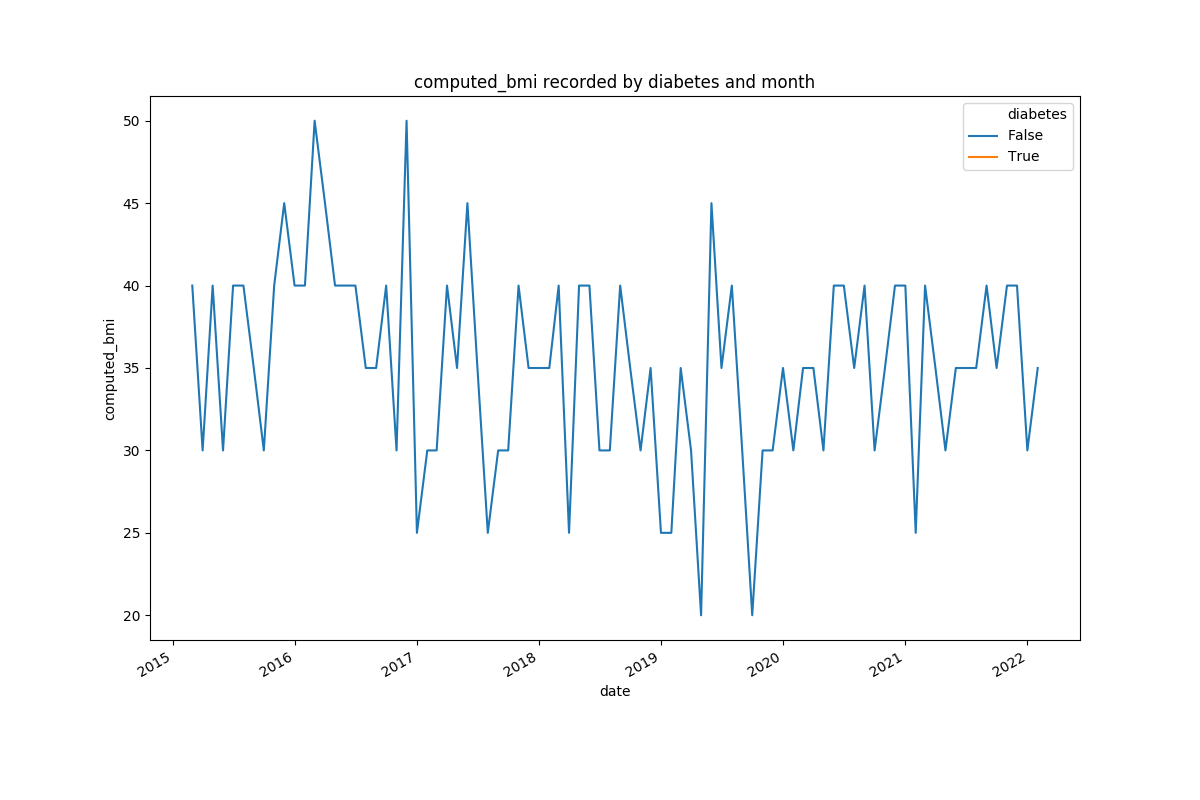

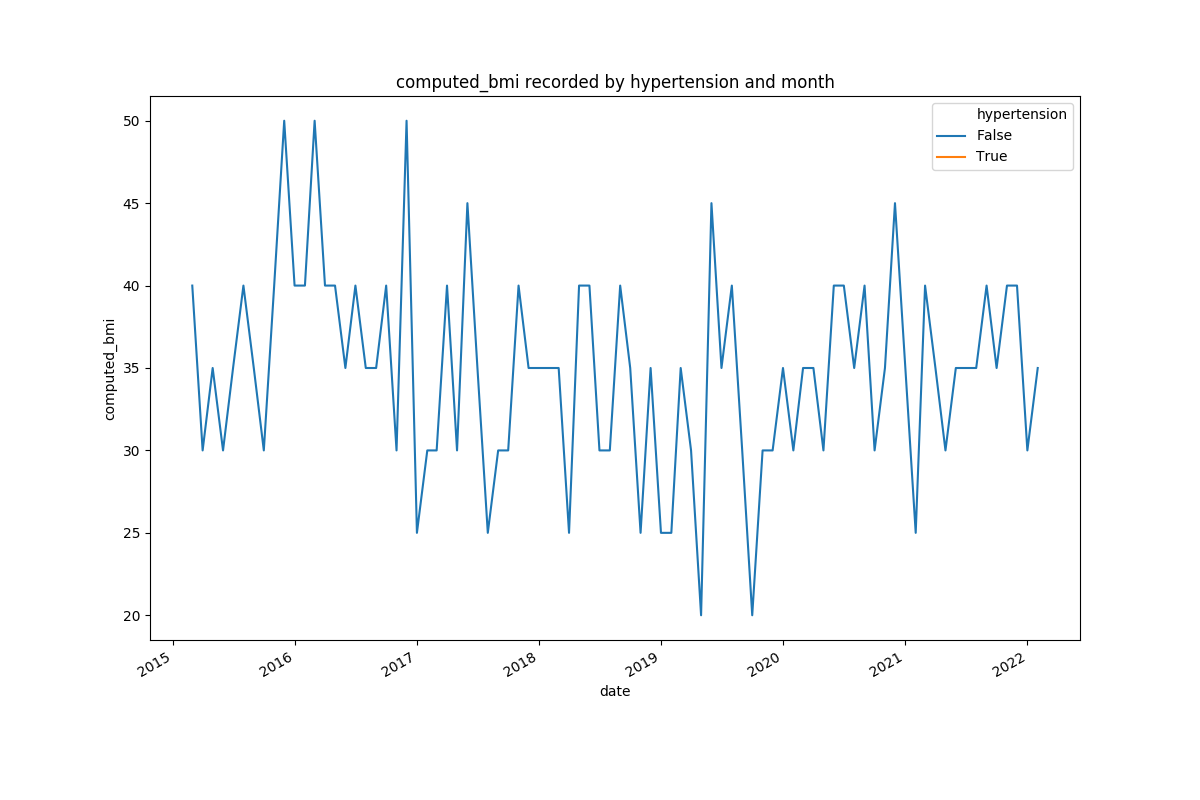

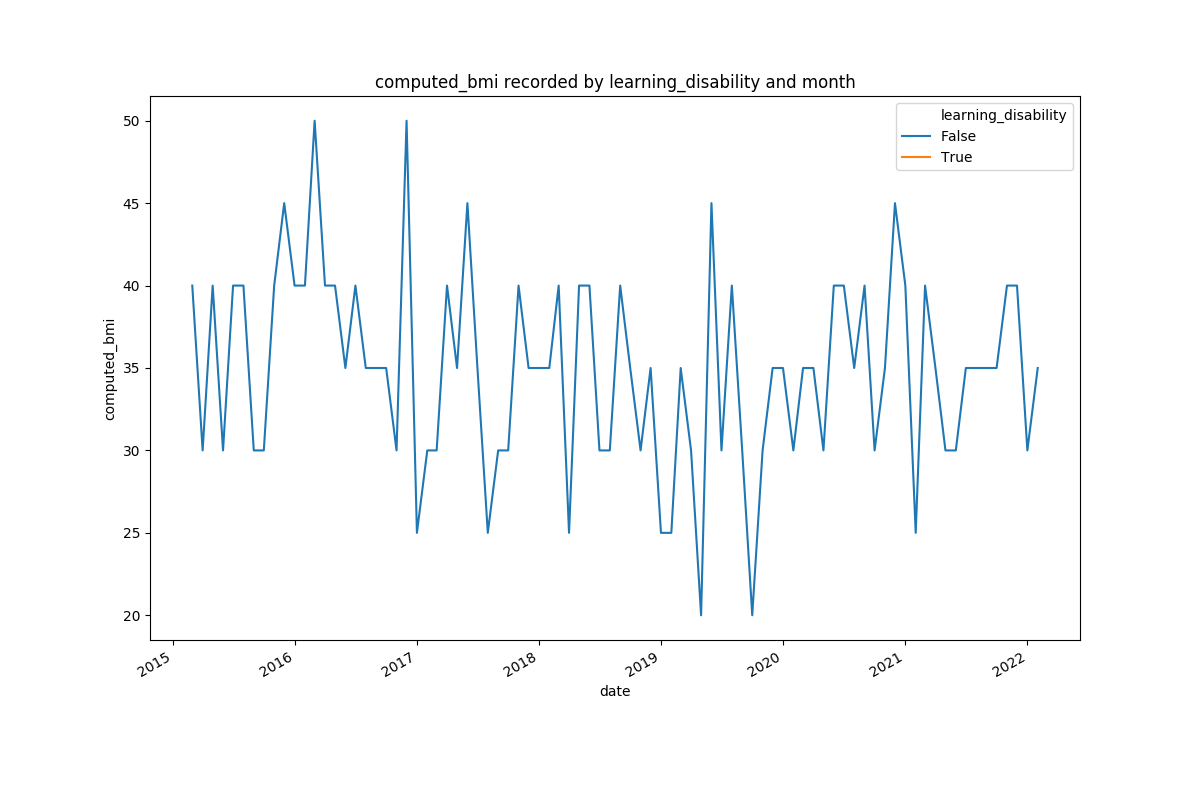

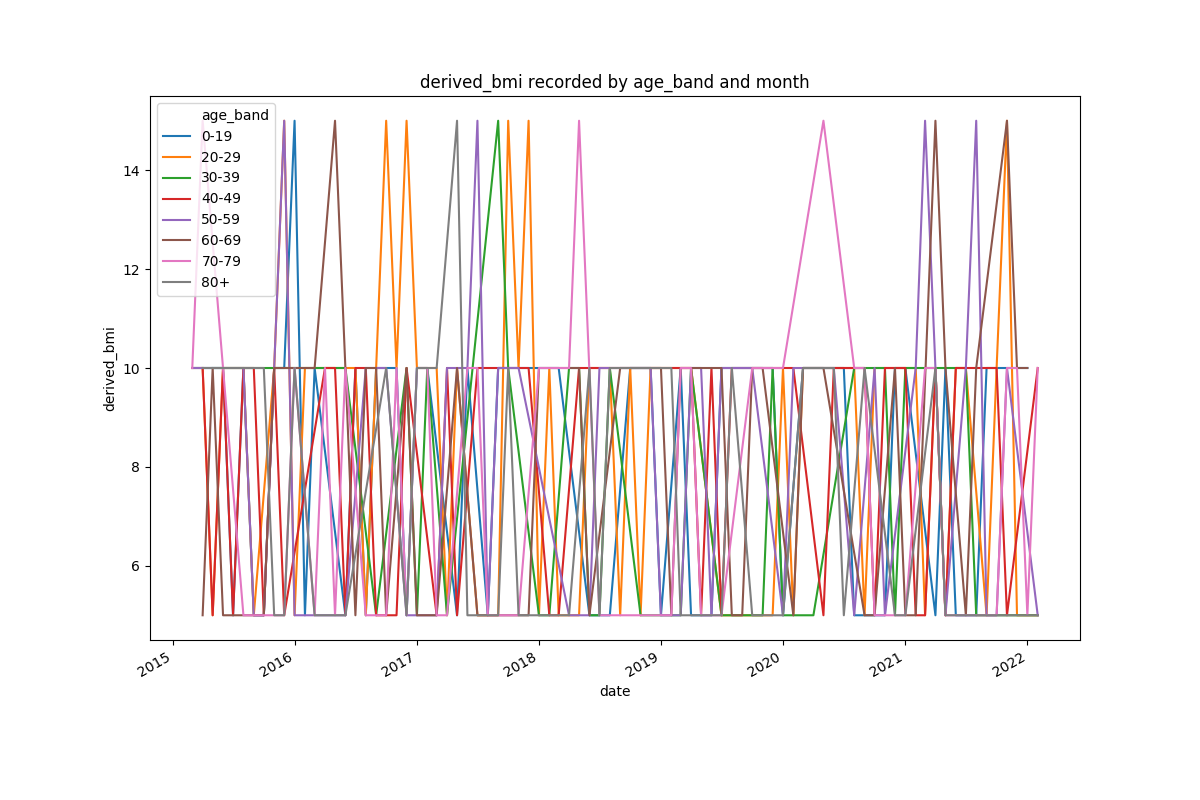

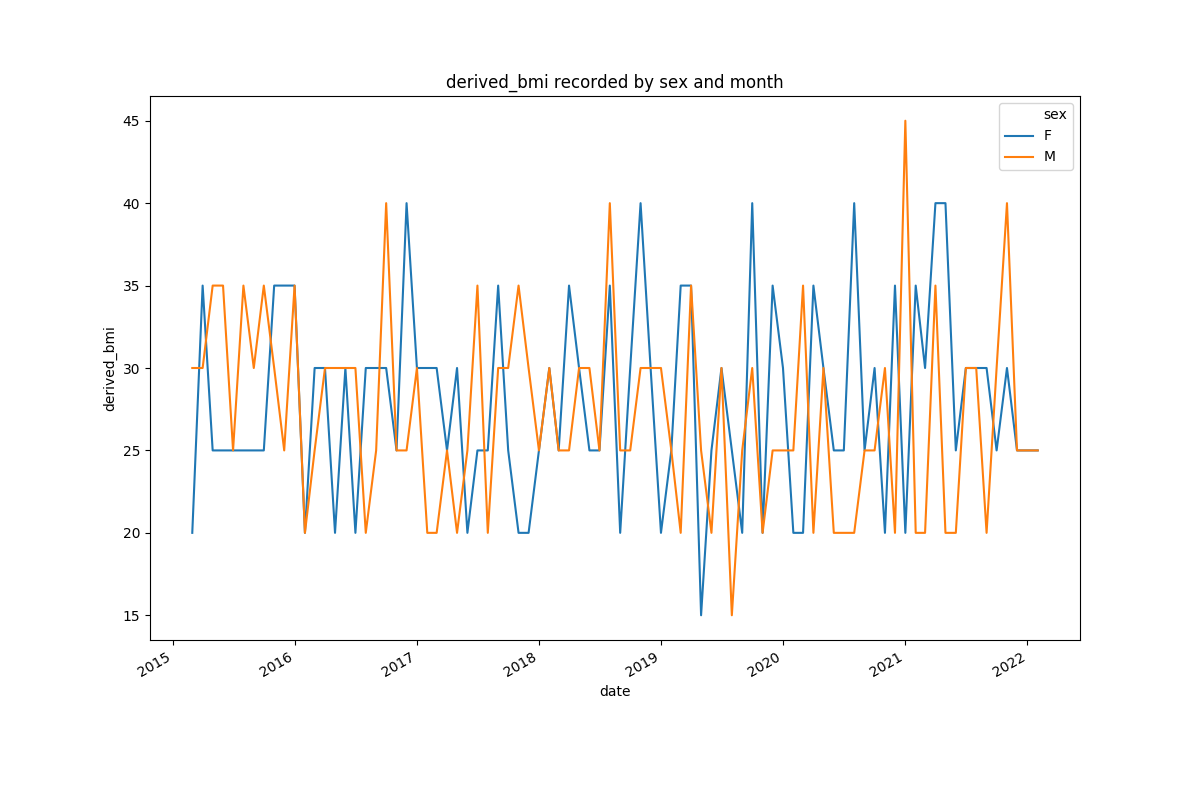

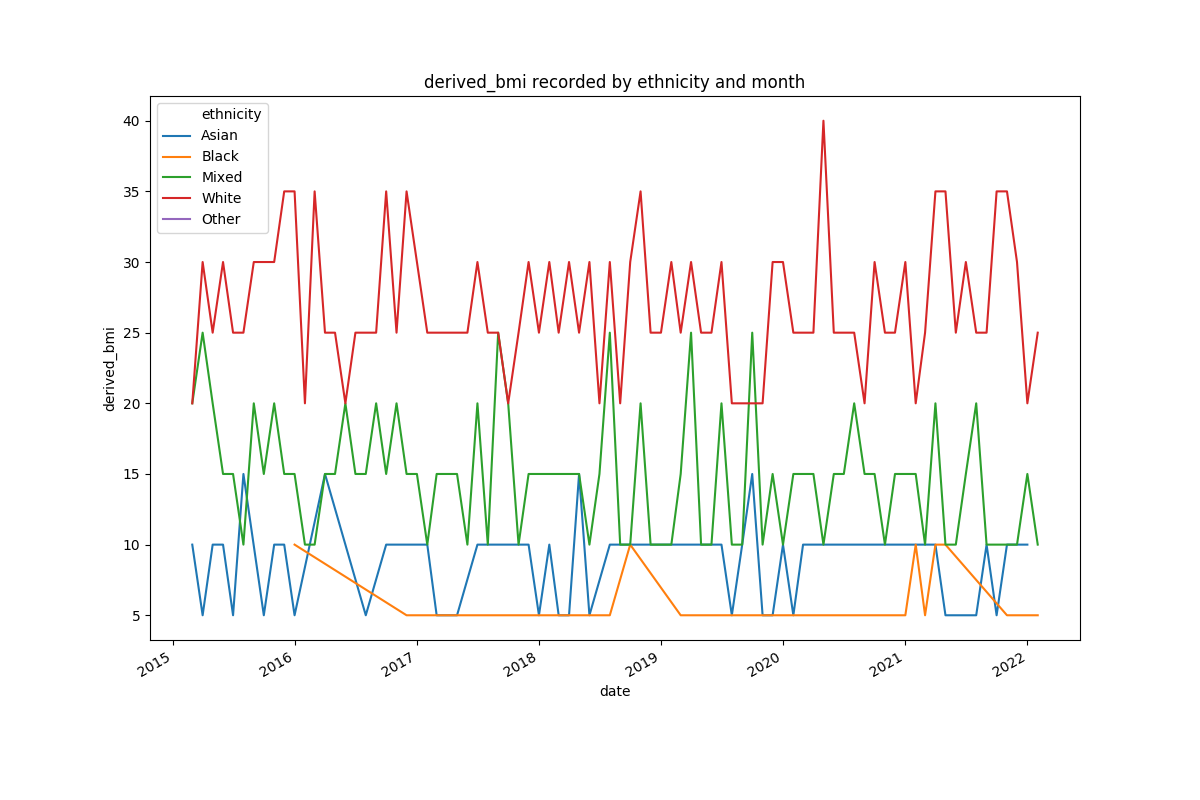

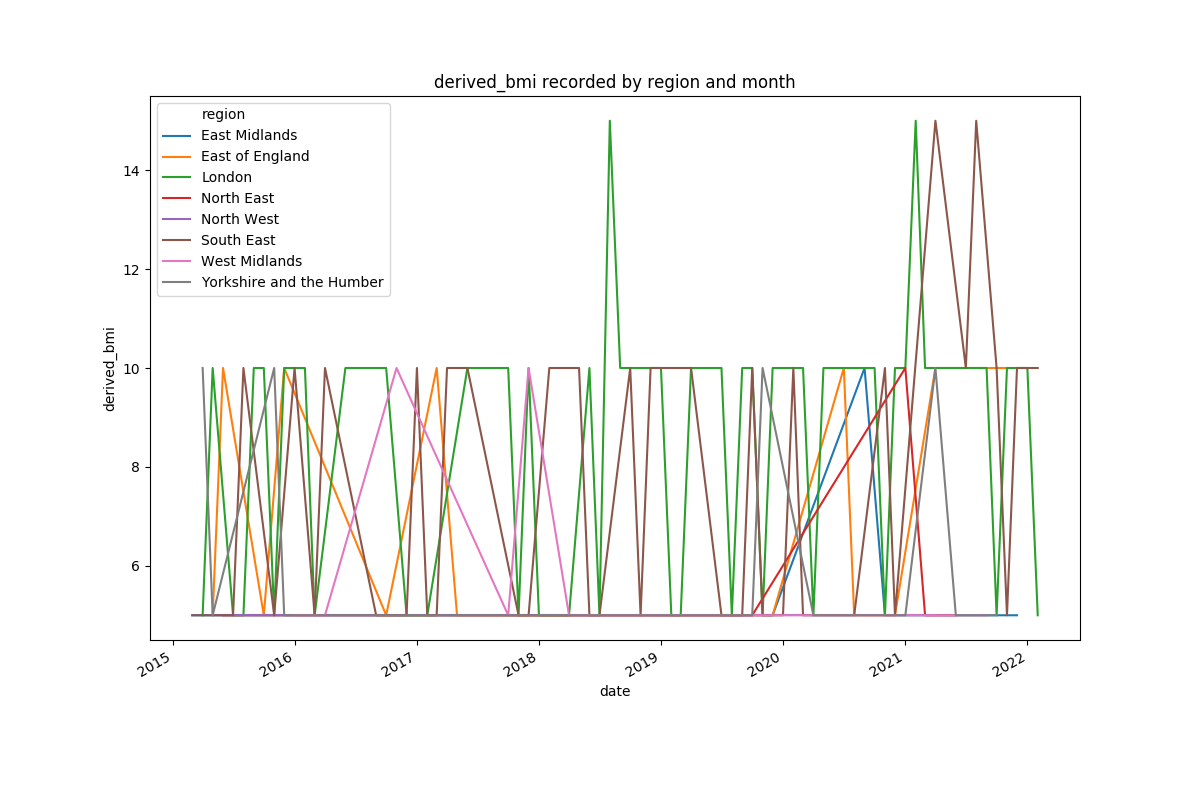

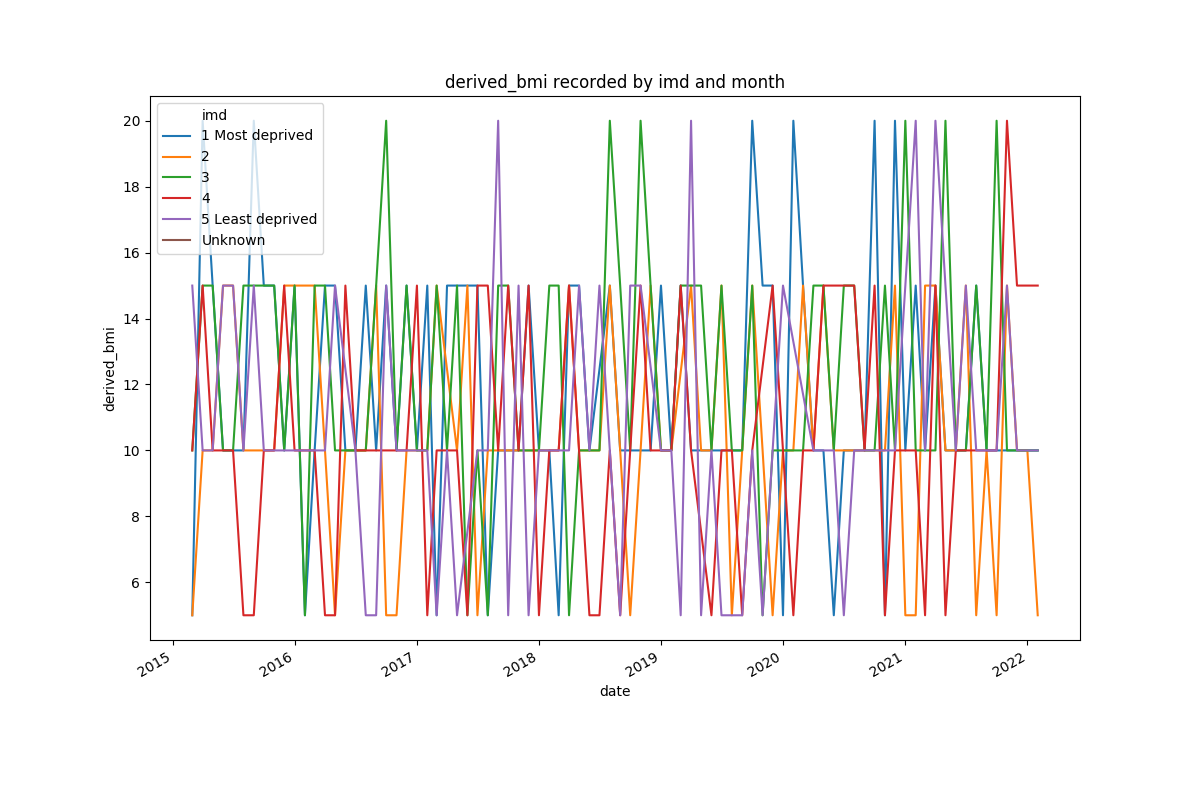

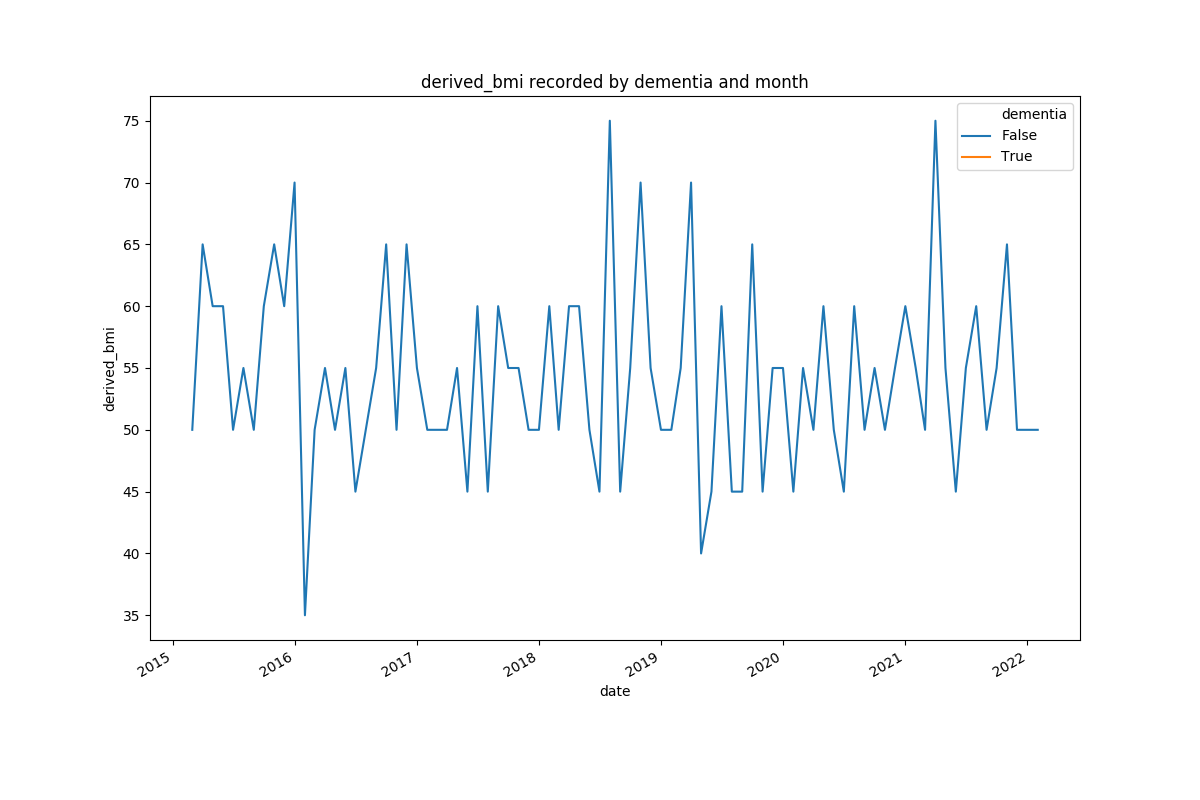

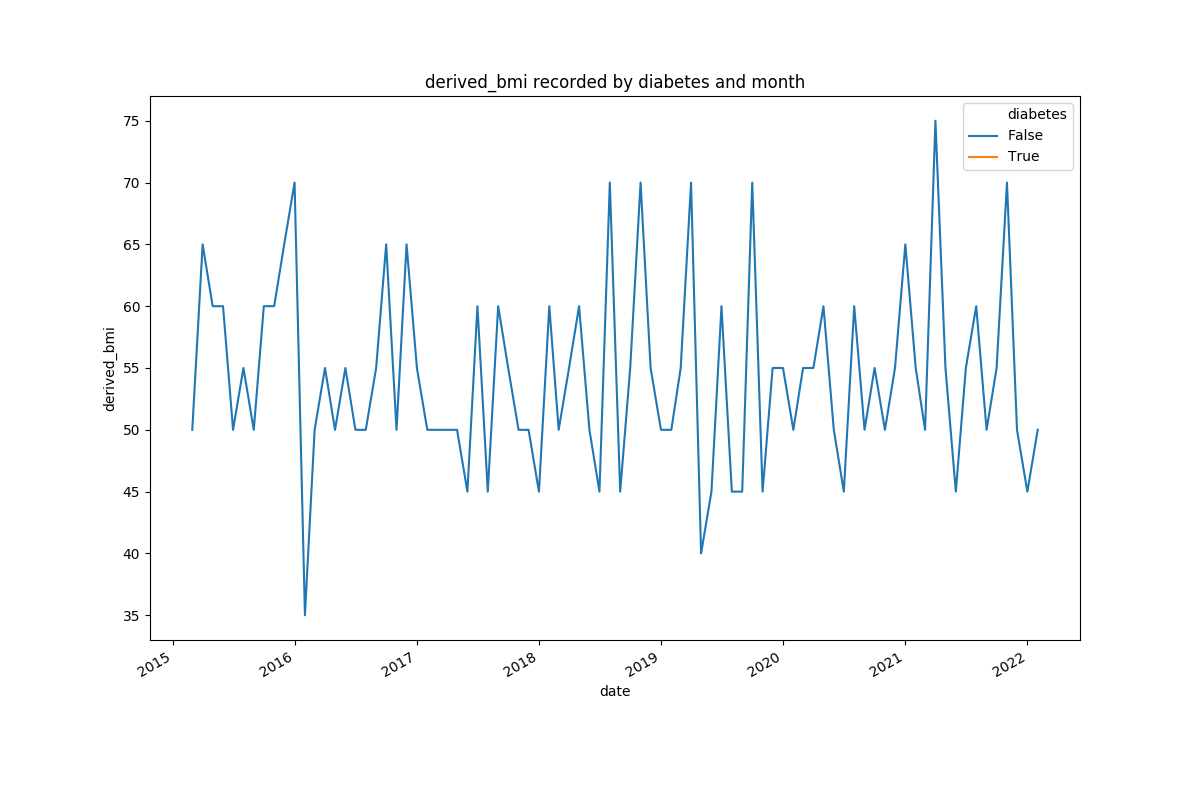

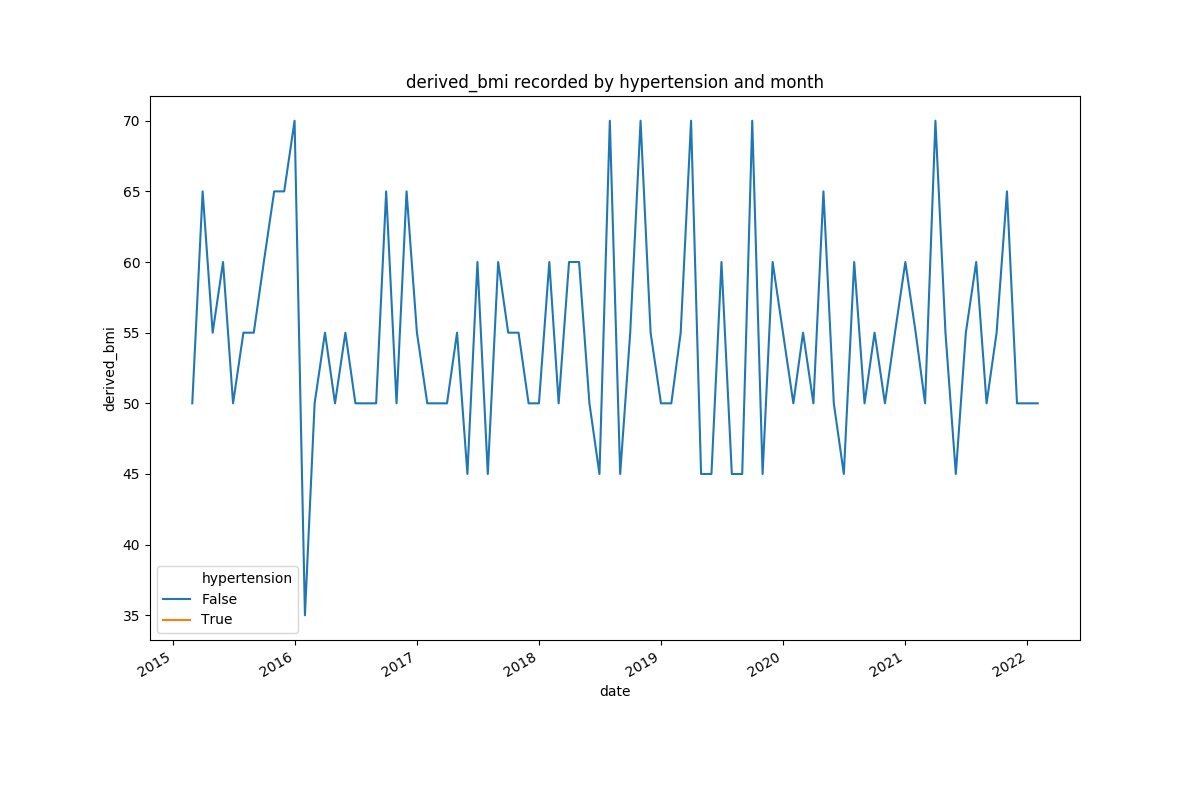

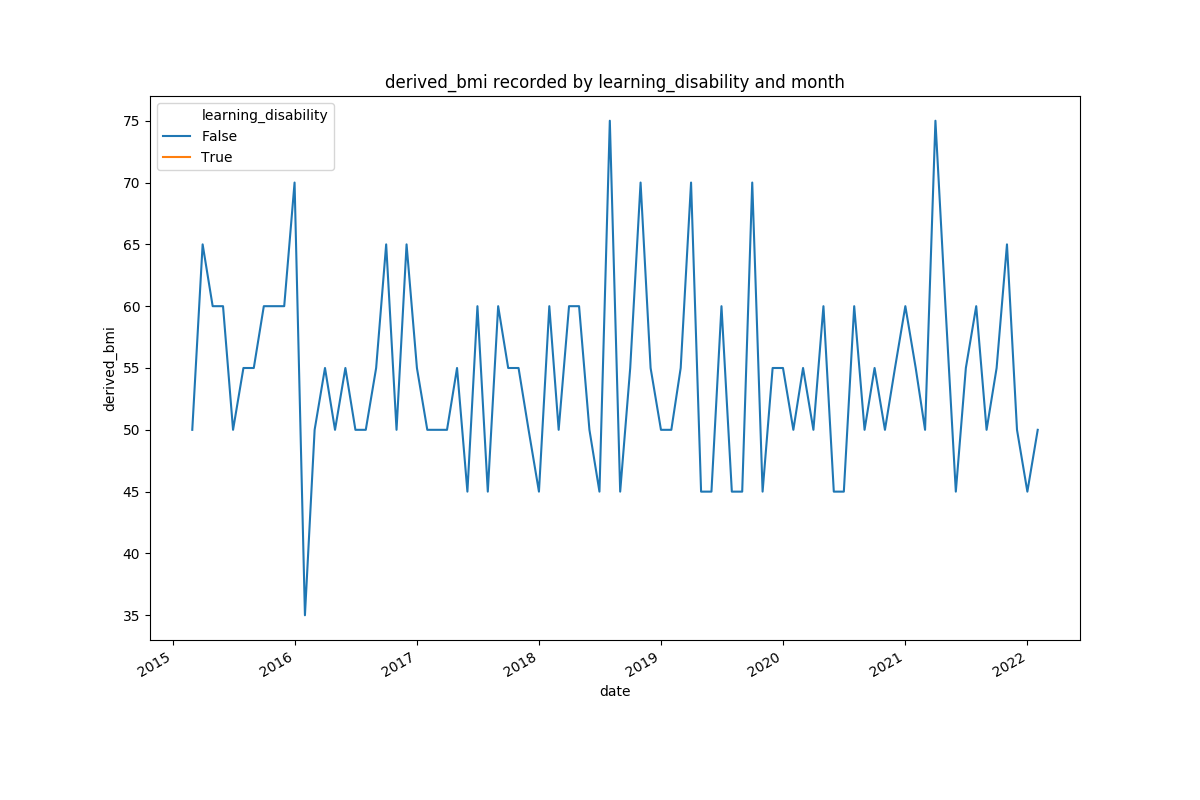

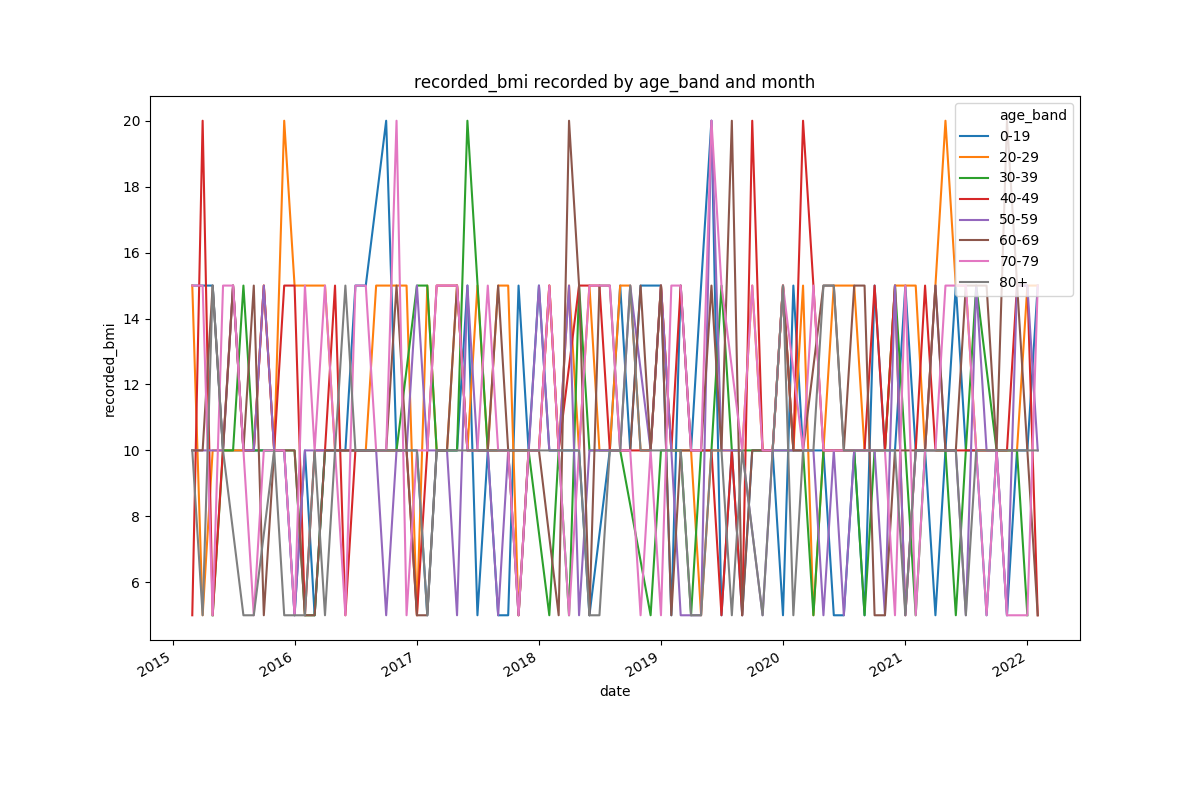

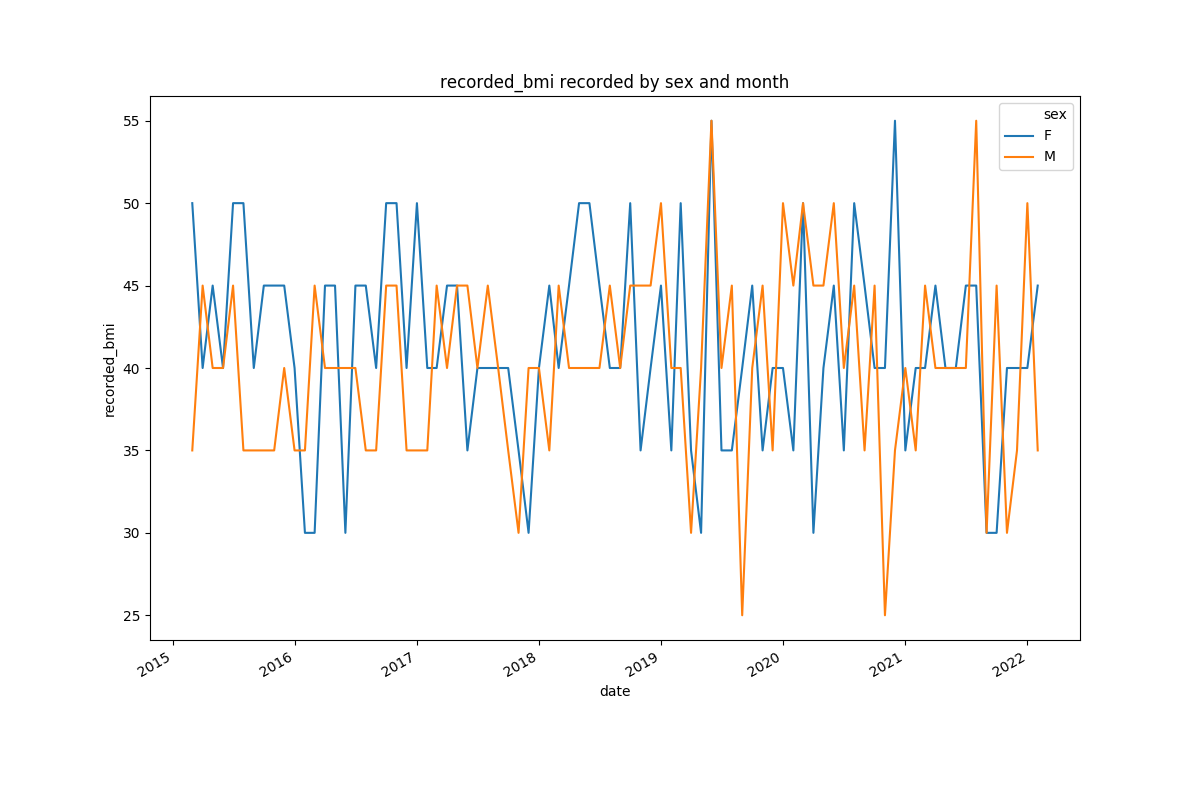

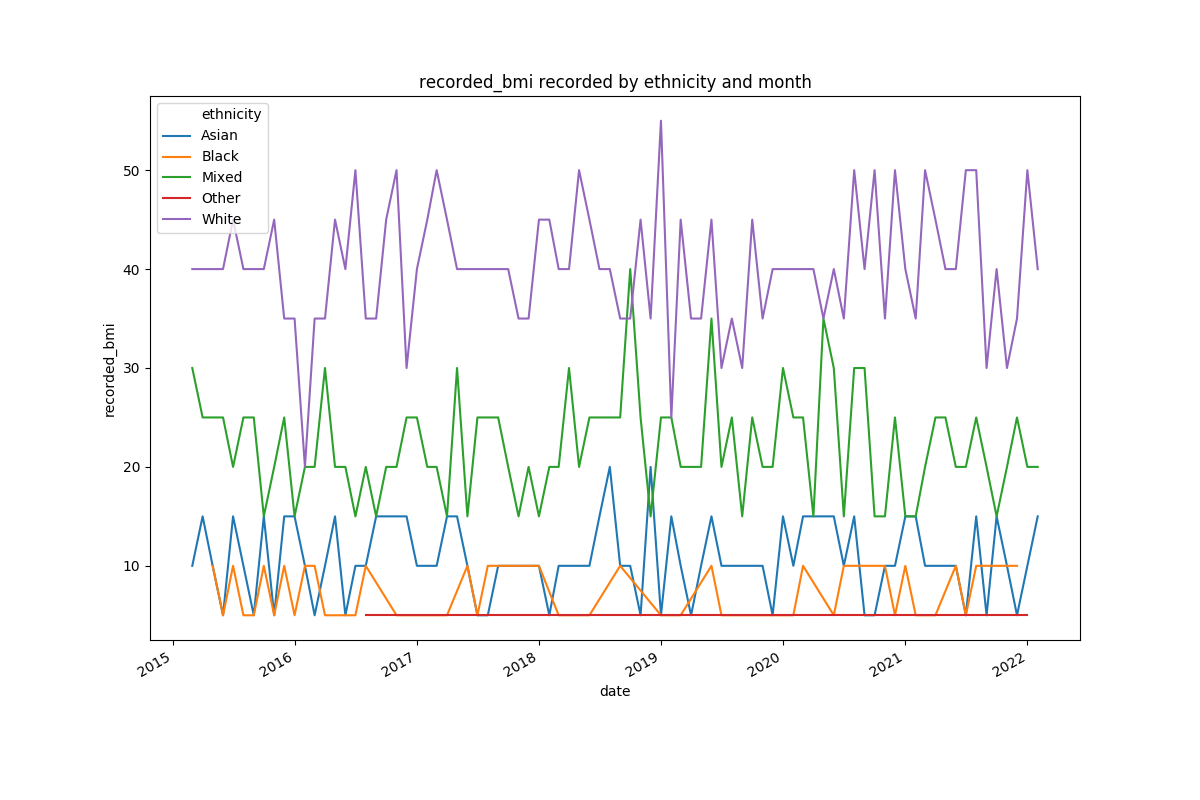

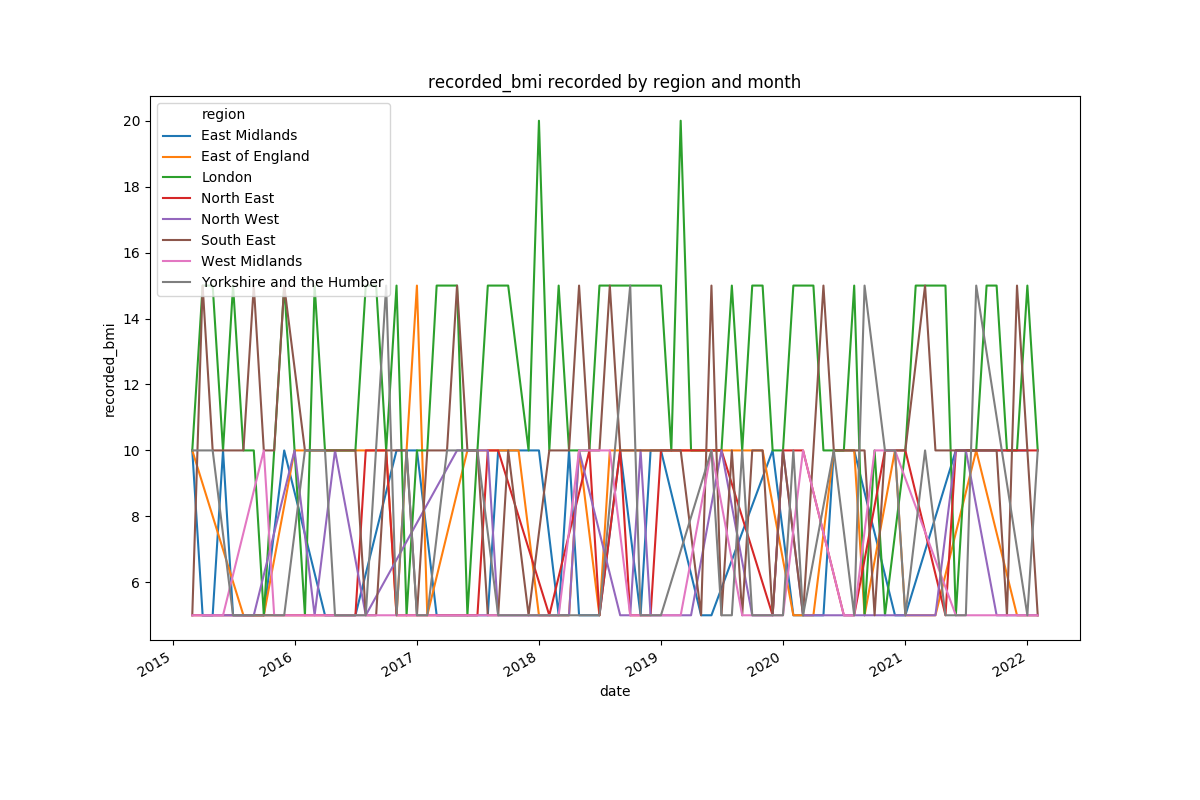

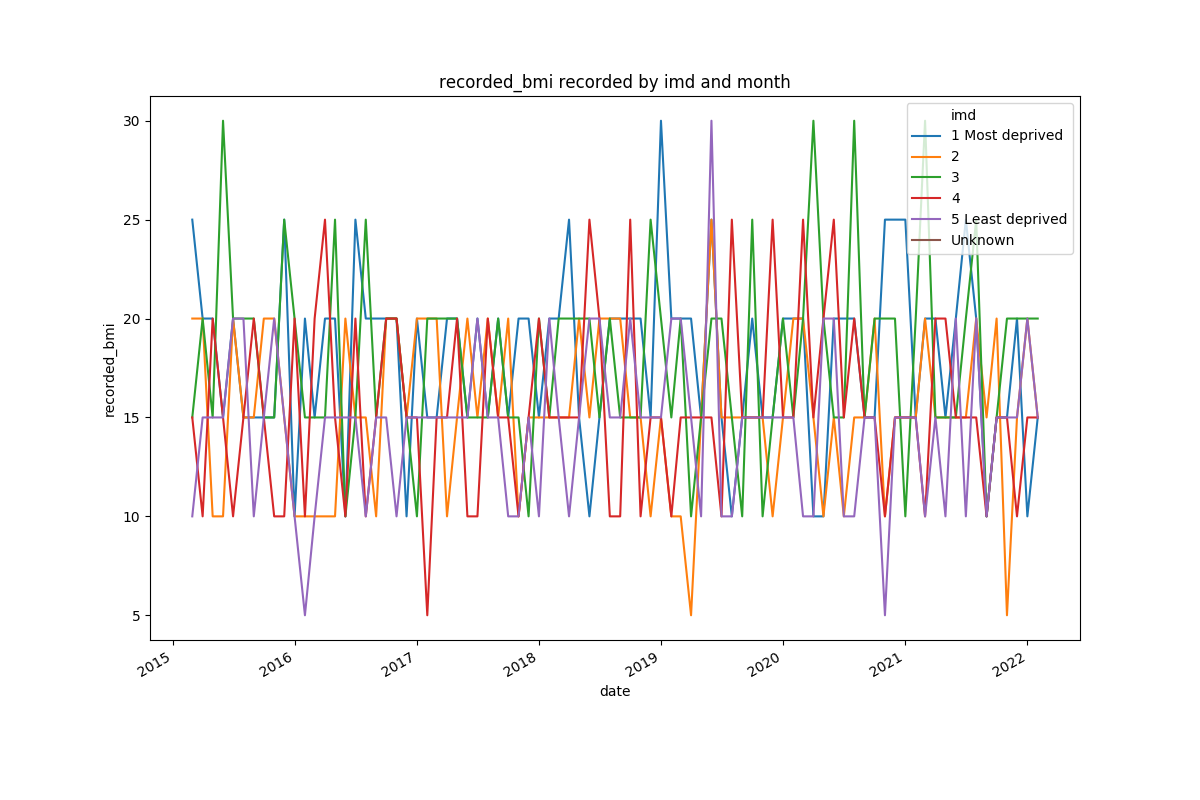

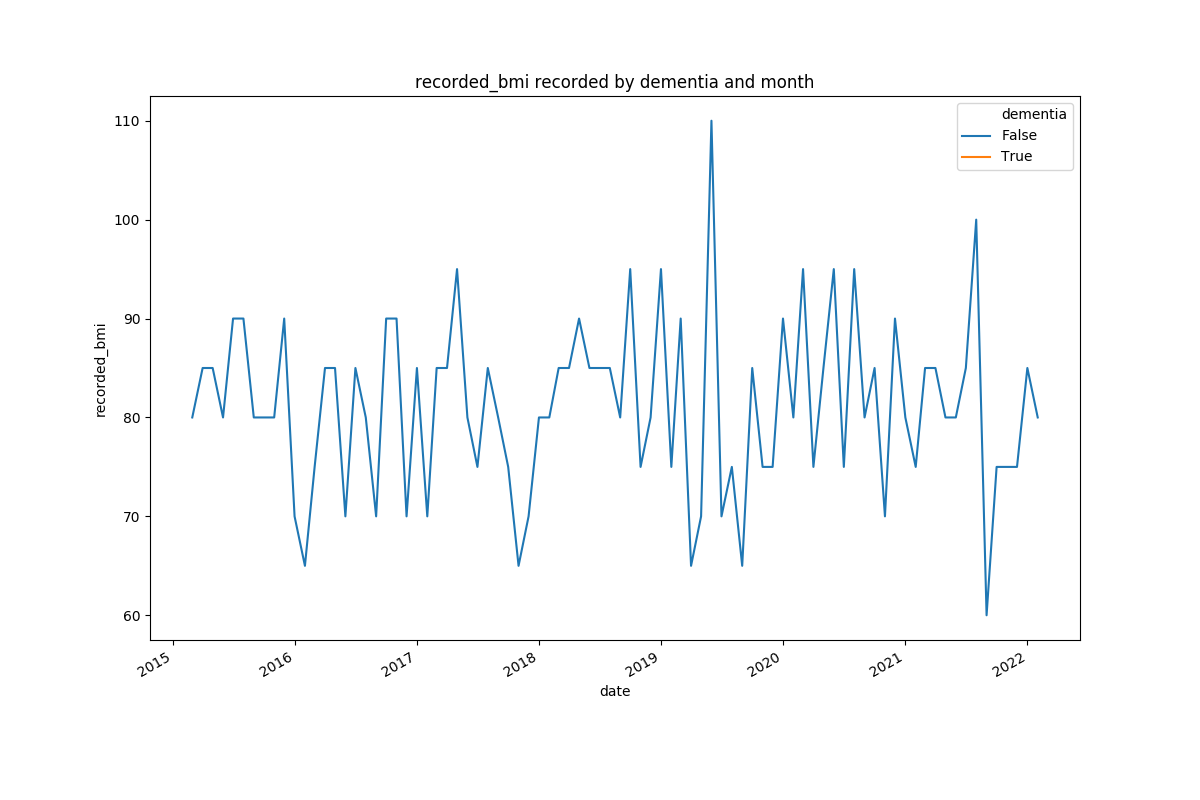

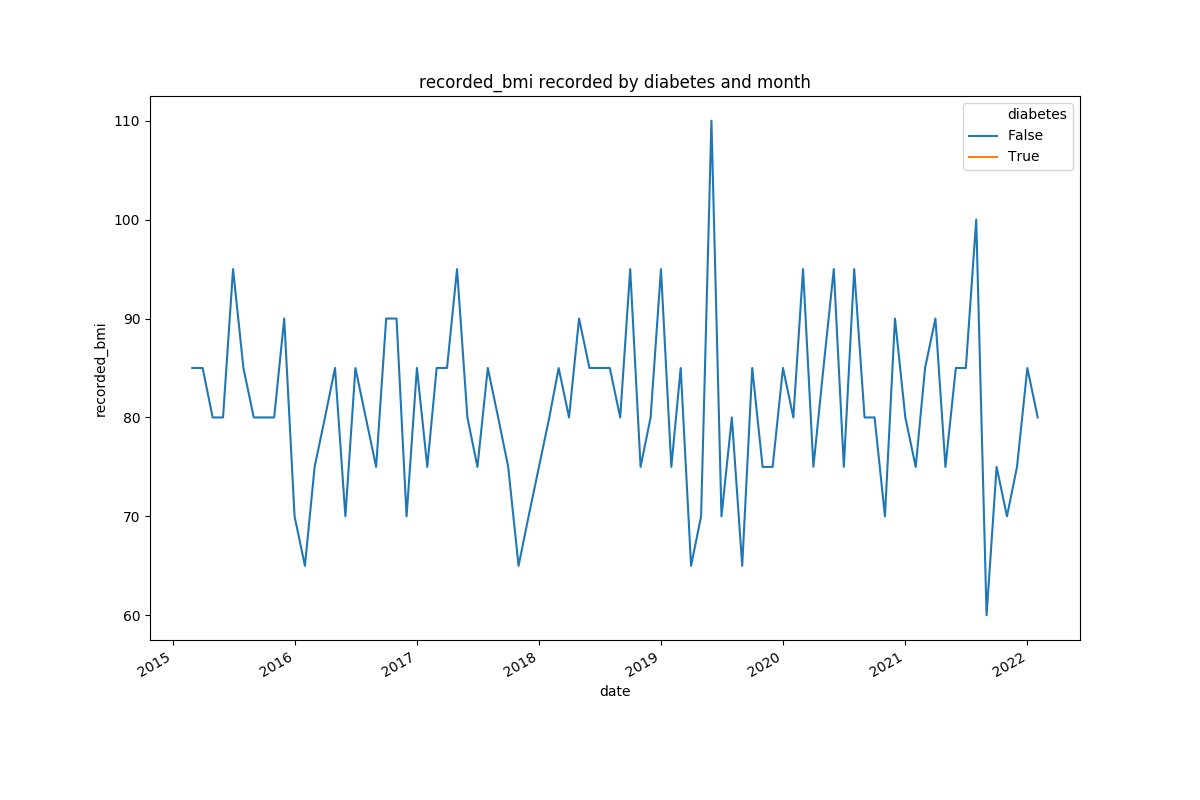

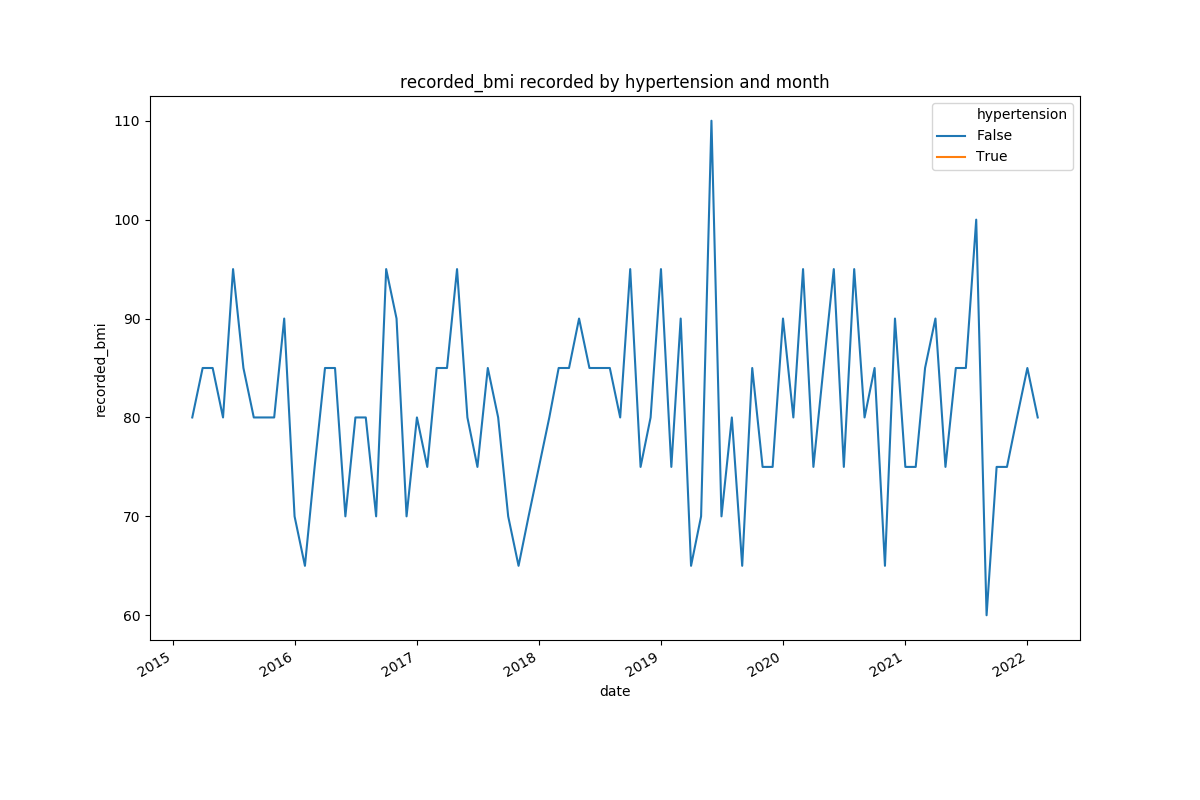

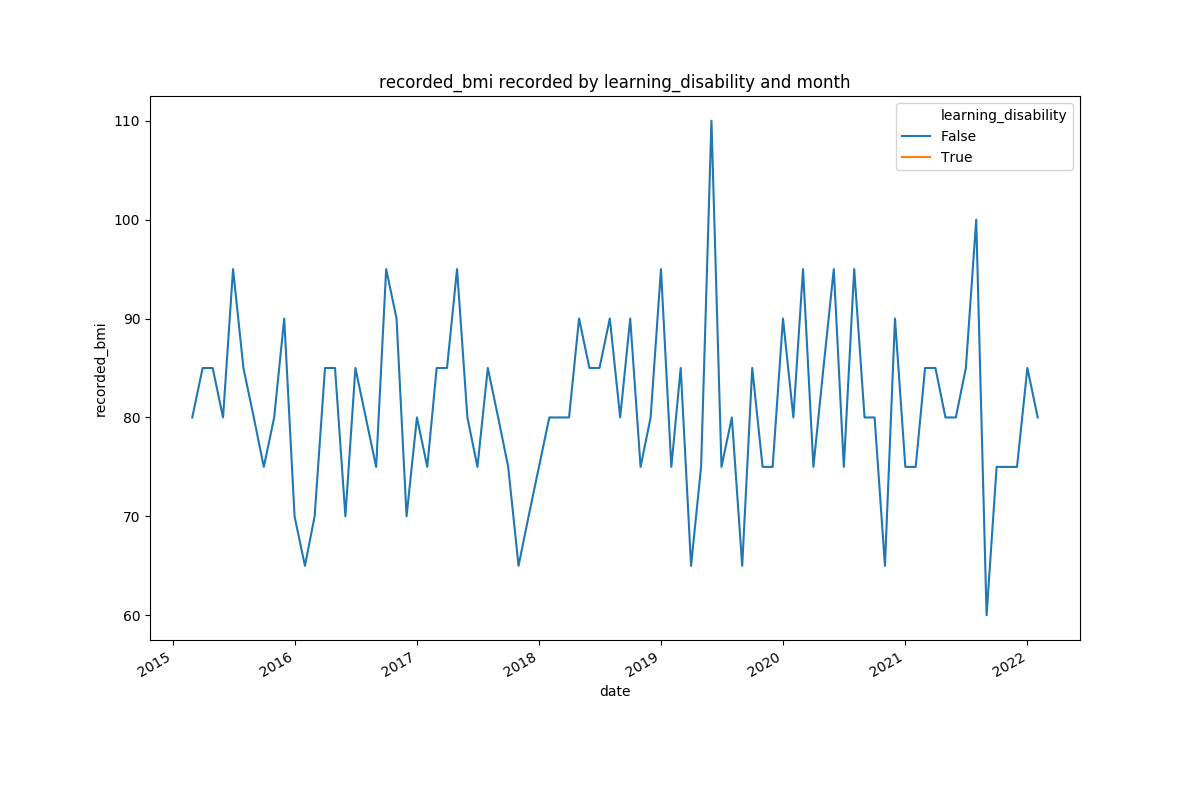

In [8]:
display(Image(f'../output/{output_path}/figures/records_over_time.png'))
for definition in definitions:
    for suffix in covariates: 
        display(Image(f'../output/{output_path}/figures/records_over_time_{definition}{suffix}.png'))

### Average Time Between Updates

In [9]:
# for suffix in ['','_age_band','_sex','_ethnicity','_region','_imd',
#                '_dementia','_diabetes','_hypertension','_learning_disability']: 
#     df_update = pd.read_csv(f'../output/{output_path}/tables/avg_update_frequency{suffix}.csv', index_col=0)
#     display(df_update)
    
#     img_exist = os.path.exists(f'../output/{output_path}/figures/avg_update_frequency{suffix}.png')
    
#     if img_exist:
#         img_update = Image(f'../output/{output_path}/figures/avg_update_frequency{suffix}.png')
#         display(img_update)
#     else: 
#         print('Plot redacted due to low counts.')
print('Removed while fixing errors...')

Removed while fixing errors...
